# Построение сетей

In [32]:
import glob
import numpy as np
import paths

def average_network(folders_in, files_out):
    """
    Создание усредненной сети.
    
    :param folders_in: Папки, где хранятся сети.
    :param files_out: Файлы усредненных сетей.
    :return: 
    """
    states_0 = ['0bk', 'win', 'l', 'story', 'rnd', 'relation', 'neut']
    states_1 = ['2bk', 'loss', 'r', 'math', 'mental', 'match', 'fear']
    
    files = sorted(glob.glob(f'{folders_in[0]}/*') + glob.glob(f'{folders_in[1]}/*') +
                   glob.glob(f'{folders_in[2]}/*') + glob.glob(f'{folders_in[3]}/*'))
    files_0 = [file for file in files if any('_' + sub + '.npy' in file.split('/')[-1] for sub in states_0)]
    files_1 = [file for file in files if any('_' + sub + '.npy' in file.split('/')[-1] for sub in states_1)]
    
    tmp1 = np.load(files_0[0])
    tmp2 = (1 + tmp1) / 2
    
    A_0 = np.mean([(1 + np.load(file)) / 2 for file in files_0], axis=0)
    A_1 = np.mean([(1 + np.load(file)) / 2 for file in files_1], axis=0)

    np.save(files_out[0], A_0)
    np.save(files_out[1], A_1)

In [33]:
average_network(paths.folders_mean_ensemble_edges_test_wm, paths.average_network_wm)
average_network(paths.folders_pca_ensemble_edges_test_gambling, paths.average_network_gambling)
average_network(paths.folders_pca_ensemble_edges_test_motor, paths.average_network_motor)
average_network(paths.folders_pca_ensemble_edges_test_language, paths.average_network_language)
average_network(paths.folders_pca_ensemble_edges_test_social, paths.average_network_social)
average_network(paths.folders_pca_ensemble_edges_test_relational, paths.average_network_relational)
average_network(paths.folders_pca_ensemble_edges_test_emotion, paths.average_network_emotion)

In [34]:
# Проверим средний вес ребер сетей
print(np.mean(np.load(paths.average_network_wm[0])), np.mean(np.load(paths.average_network_wm[1])))
print(np.mean(np.load(paths.average_network_gambling[0])), np.mean(np.load(paths.average_network_gambling[1])))
print(np.mean(np.load(paths.average_network_motor[0])), np.mean(np.load(paths.average_network_motor[1])))
print(np.mean(np.load(paths.average_network_language[0])), np.mean(np.load(paths.average_network_language[1])))
print(np.mean(np.load(paths.average_network_social[0])), np.mean(np.load(paths.average_network_social[1])))
print(np.mean(np.load(paths.average_network_relational[0])), np.mean(np.load(paths.average_network_relational[1])))
print(np.mean(np.load(paths.average_network_emotion[0])), np.mean(np.load(paths.average_network_emotion[1])))

0.3890478506709093 0.6109928931595916
0.44986172928670604 0.5496053639932006
0.3680195663960863 0.6316700495544366
0.2784598466118063 0.7220228168835561
0.39708780135986094 0.6029114645602455
0.3875576660012979 0.6119841338568688
0.46118246795408235 0.5391812717801574


# Исследование распределений весов ребер


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import paths

def weight_distribution(file0, file1, quantiles, bins=75):
    """
    Изображение распределений весов ребер двух ансамблевых графов.
    
    :param file0: Файл графа первого состояния.
    :param file1: Файл графа второго состояния.
    :param quantiles: Квантили, которые нужно изобразить. 
    :param bins: Число столбцов в гистограмме.
    :param shift: Нужно ли делать сдвиг весов.
    :return: 
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    matrices = [np.load(file0), np.load(file1)]
    titles = [file0.split('/')[-1][:-4], file1.split('/')[-1][:-4]]
    
    for ax, mat, title, qs in zip(axes, matrices, titles, [1 - np.array(quantiles), np.array(quantiles)]):
        # Заменяем диагональные элементы на NaN
        np.fill_diagonal(mat, np.nan)
        # Получаем веса в виде одномерного массива и отфильтровываем NaN
        weights = mat.flatten()
        weights = weights[~np.isnan(weights)]
        
        # Вычисляем заданный квантиль
        q_values = np.quantile(weights, qs)
        
        # Строим гистограмму распределения весов
        ax.hist(weights, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
        for q, q_value in zip(qs, q_values):
            ax.axvline(q_value, color='red', linestyle='dashed', linewidth=1.5,
                       label=f'Quantile {q:.2f}: {q_value:.3f}')

        ax.set_xlabel('Weight')
        ax.set_ylabel('Frequency')
        ax.set_title(title)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

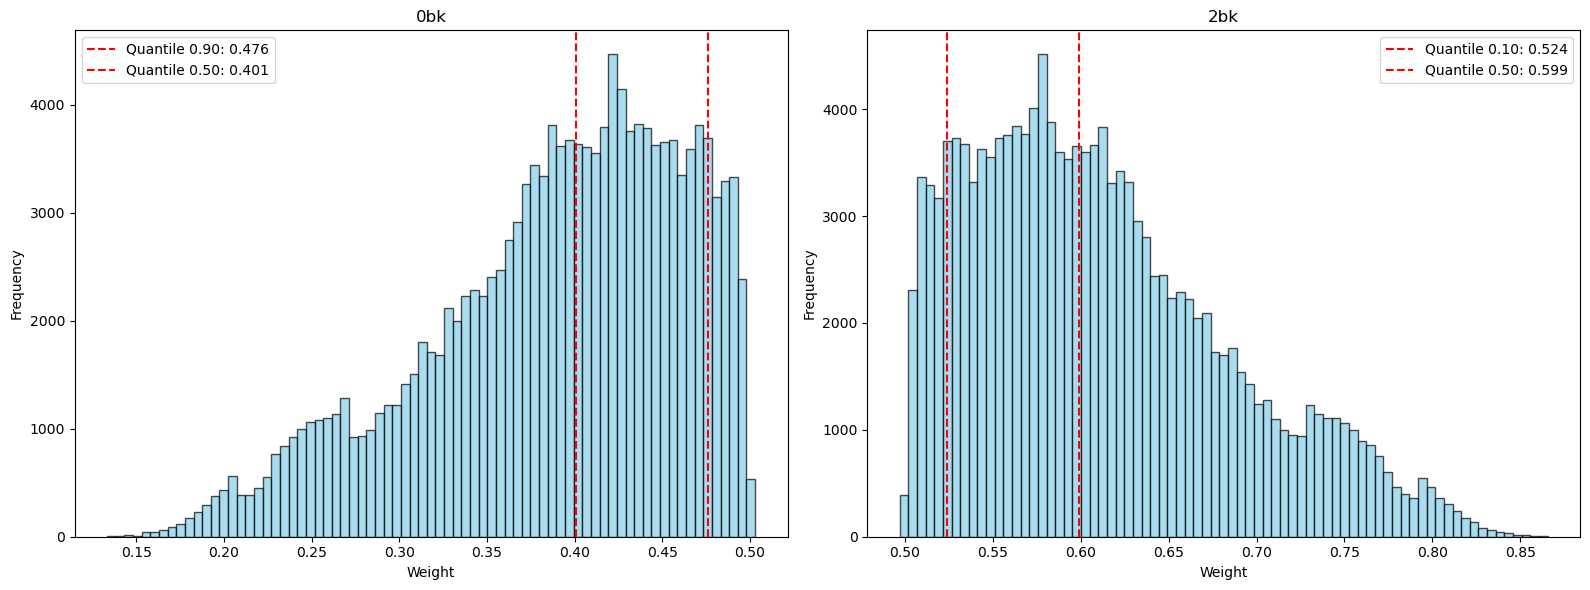

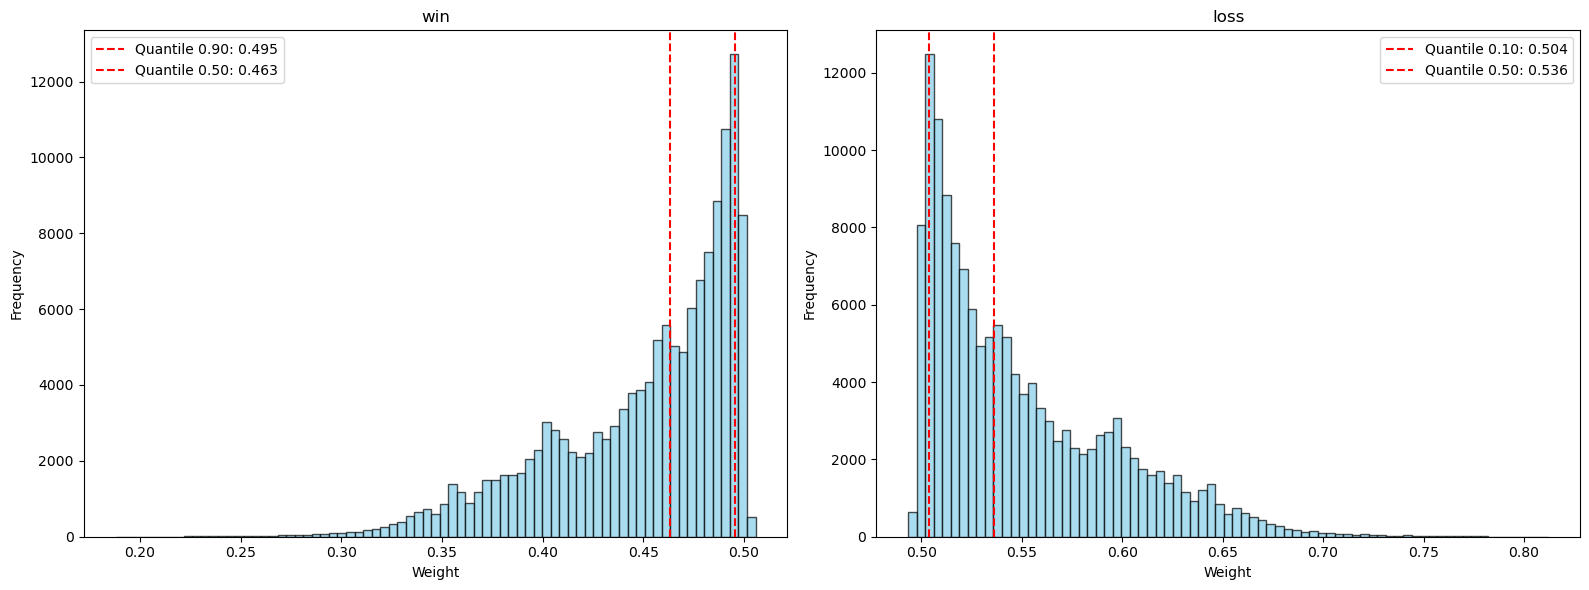

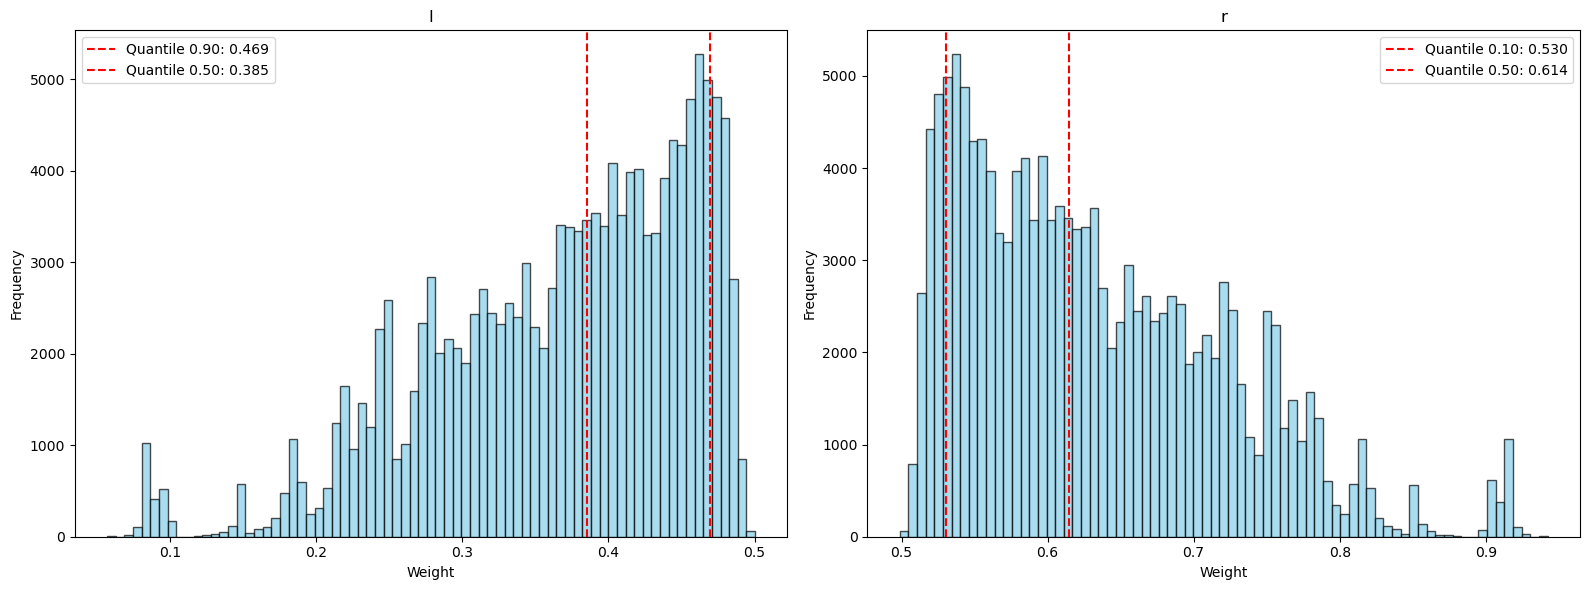

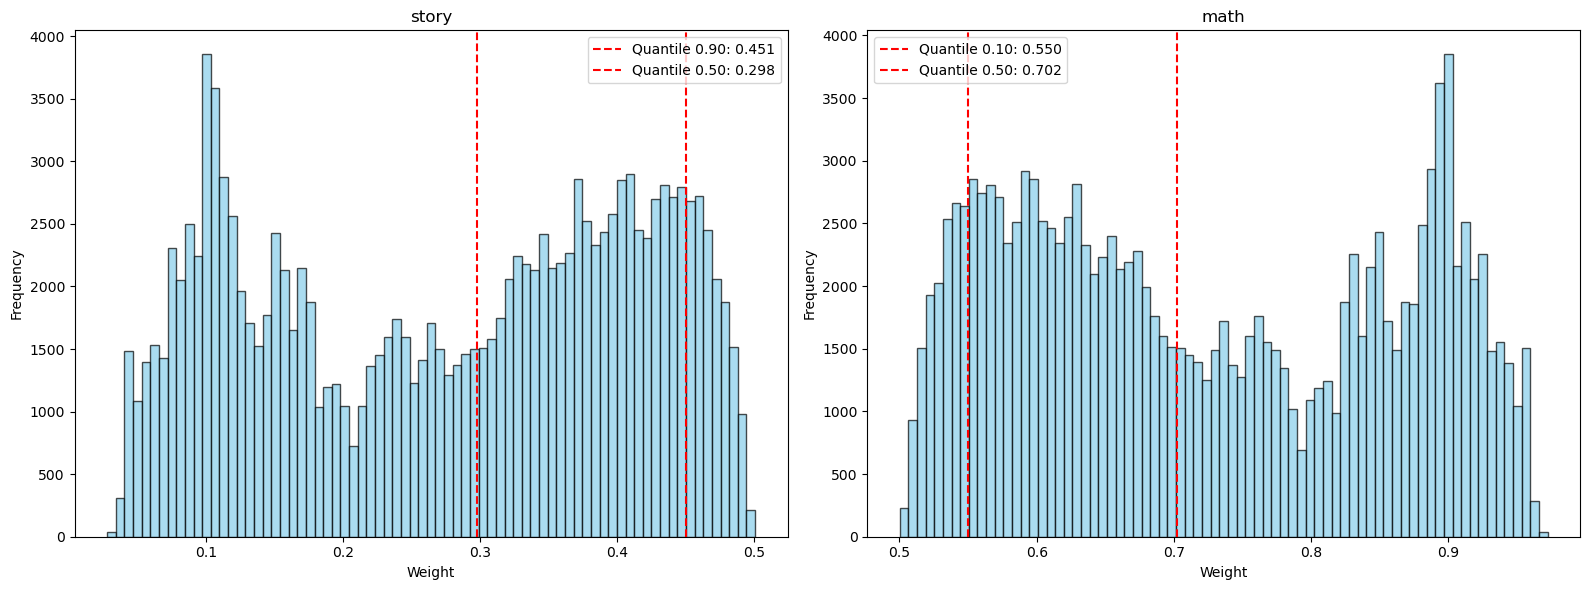

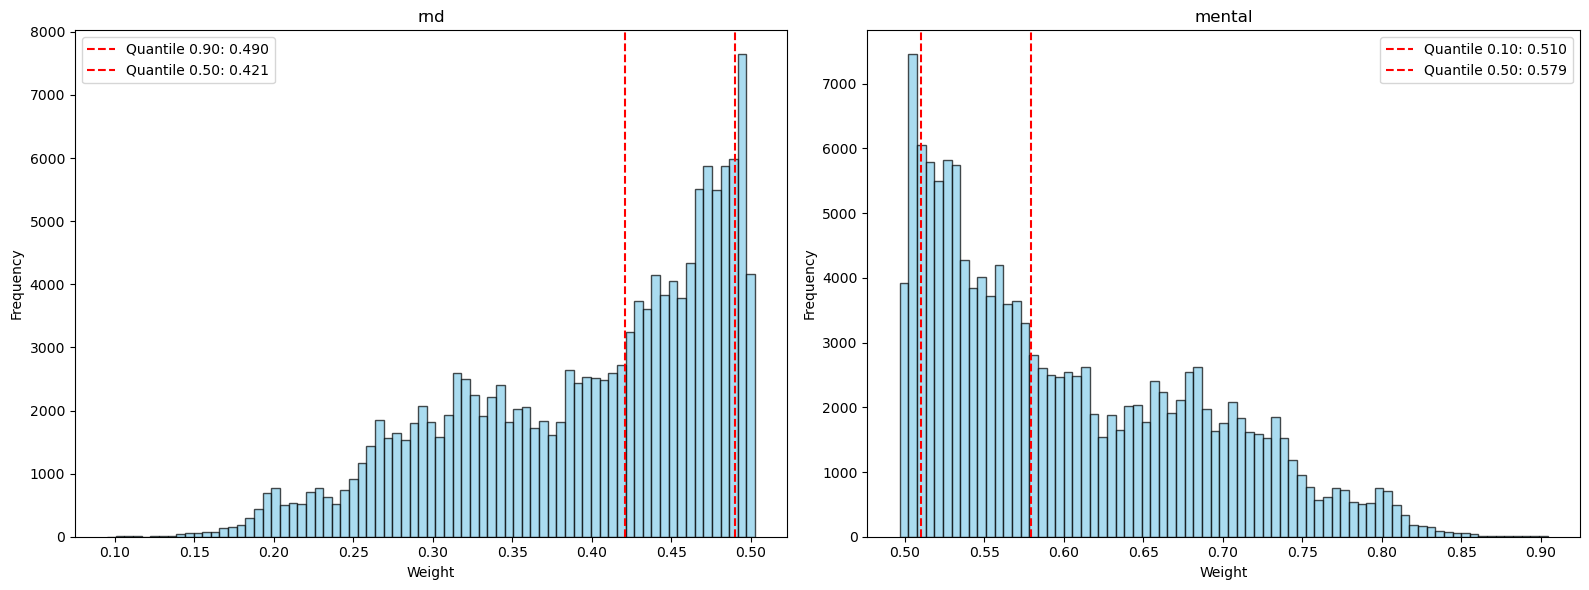

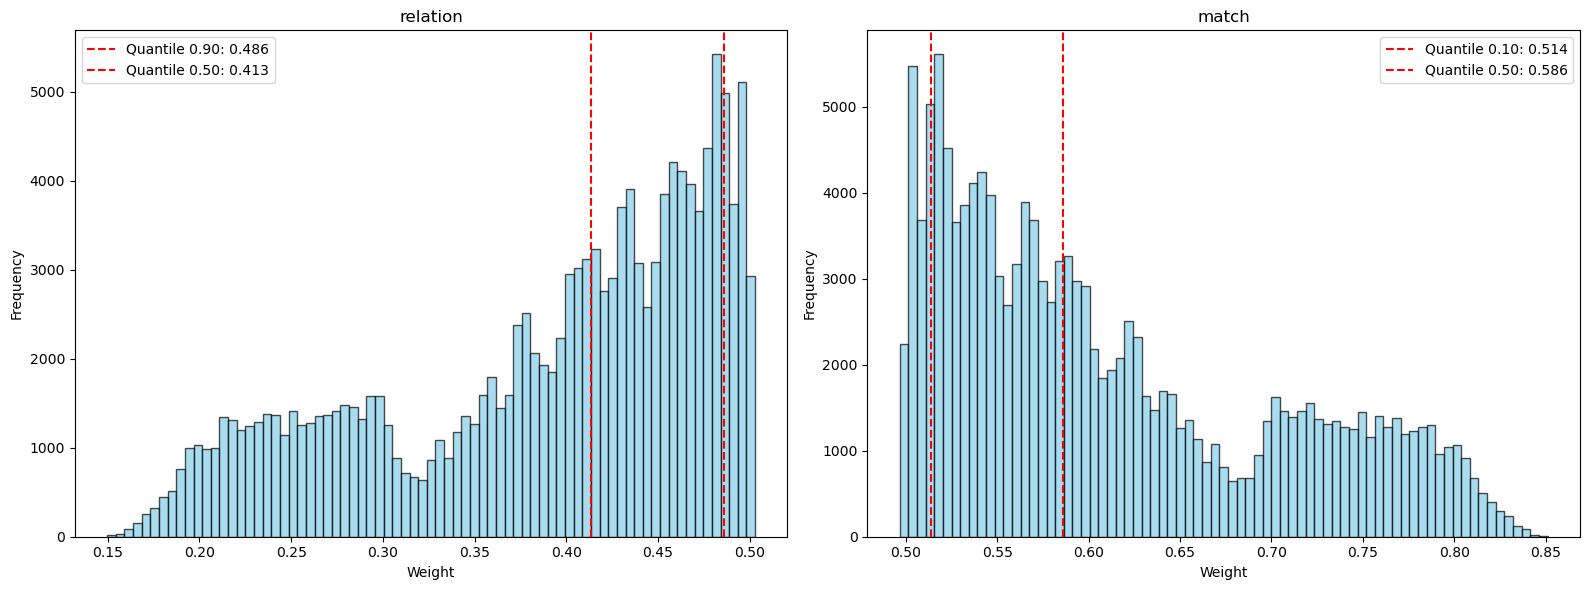

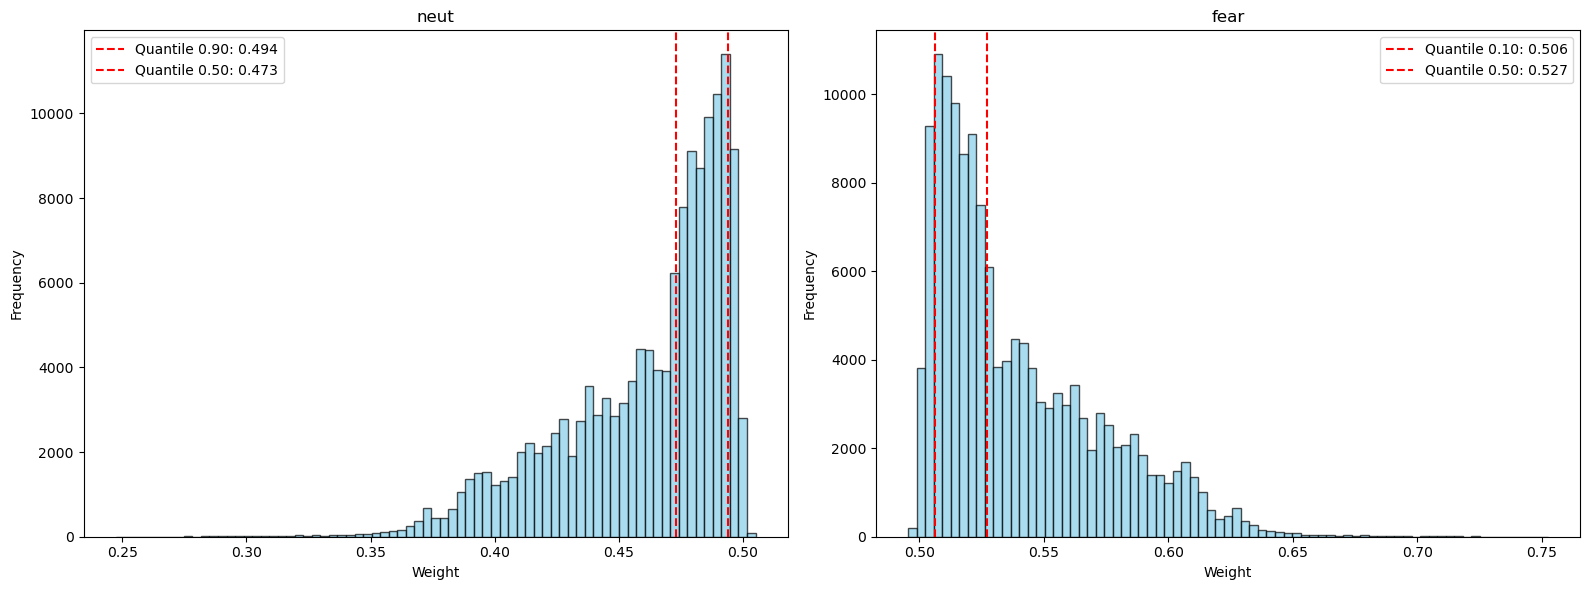

In [36]:
quantiles = [0.1, 0.5]
weight_distribution(paths.average_network_wm[0], paths.average_network_wm[1], quantiles)
weight_distribution(paths.average_network_gambling[0], paths.average_network_gambling[1], quantiles)
weight_distribution(paths.average_network_motor[0], paths.average_network_motor[1], quantiles)
weight_distribution(paths.average_network_language[0], paths.average_network_language[1], quantiles)
weight_distribution(paths.average_network_social[0], paths.average_network_social[1], quantiles)
weight_distribution(paths.average_network_relational[0], paths.average_network_relational[1], quantiles)
weight_distribution(paths.average_network_emotion[0], paths.average_network_emotion[1], quantiles)

Я решил пока продолжить исследование графов без фильтрации.

# Распределение степеней


In [58]:
import numpy as np
import paths
import matplotlib.pyplot as plt
import networkx as nx

def read_nets(file0, file1, reflect):
    if reflect:
        Gs = [nx.from_numpy_array(1 - np.load(file0)), nx.from_numpy_array(np.load(file1))]
    else:
        Gs = [nx.from_numpy_array(np.load(file0)), nx.from_numpy_array(np.load(file1))]
    titles = [file0.split('/')[-1][:-4], file1.split('/')[-1][:-4]]
    return Gs, titles


def degree_distribution(file0, file1, bins=75):
    """
    Изображение распределений весов ребер двух ансамблевых графов.
    
    :param file0: Файл графа первого состояния.
    :param file1: Файл графа второго состояния.
    :param bins: Число столбцов в гистограмме.
    :param shift: Нужно ли делать сдвиг весов.
    :return: 
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    Gs, titles = read_nets(file0, file1)
    
    for ax, G, title in zip(axes, Gs, titles):
        degrees = np.array([d for n, d in G.degree(weight='weight')]) / len(G.nodes)  
        
        # Строим гистограмму распределения весов
        ax.hist(degrees, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
        ax.set_xlabel('Degree')
        # ax.set_ylabel('Value')
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

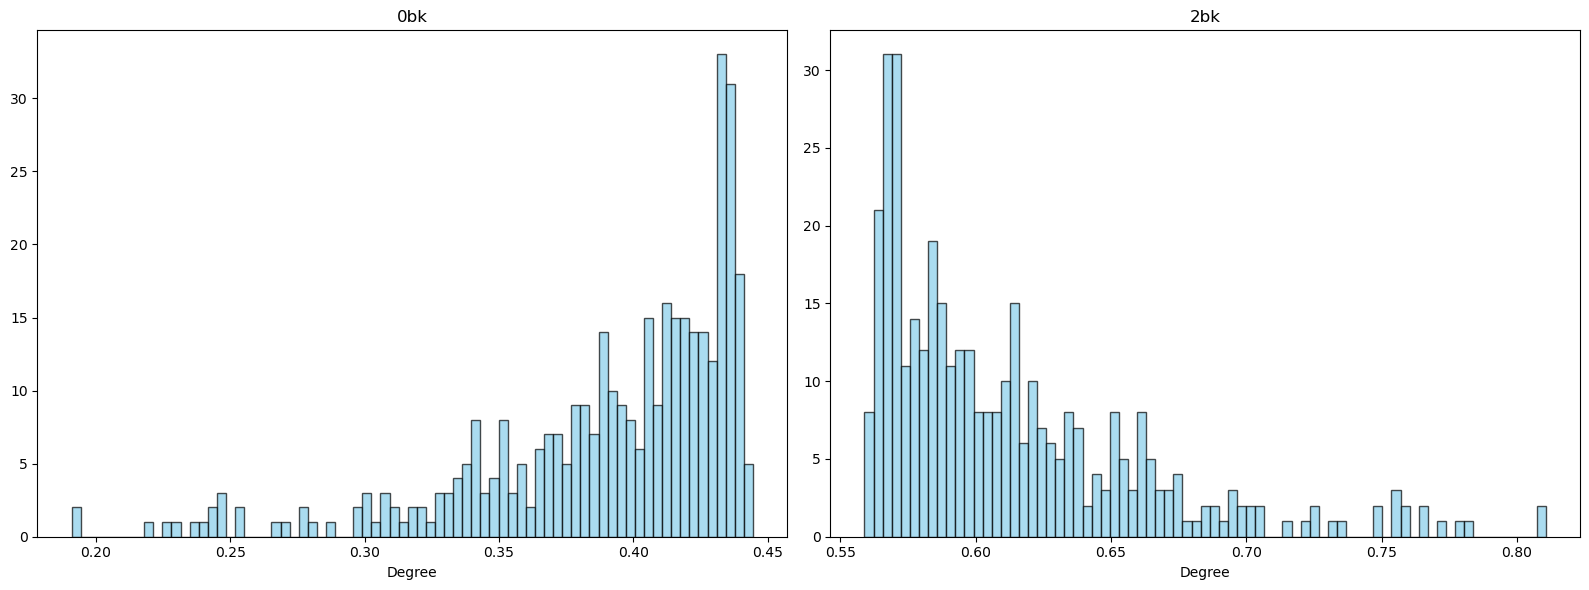

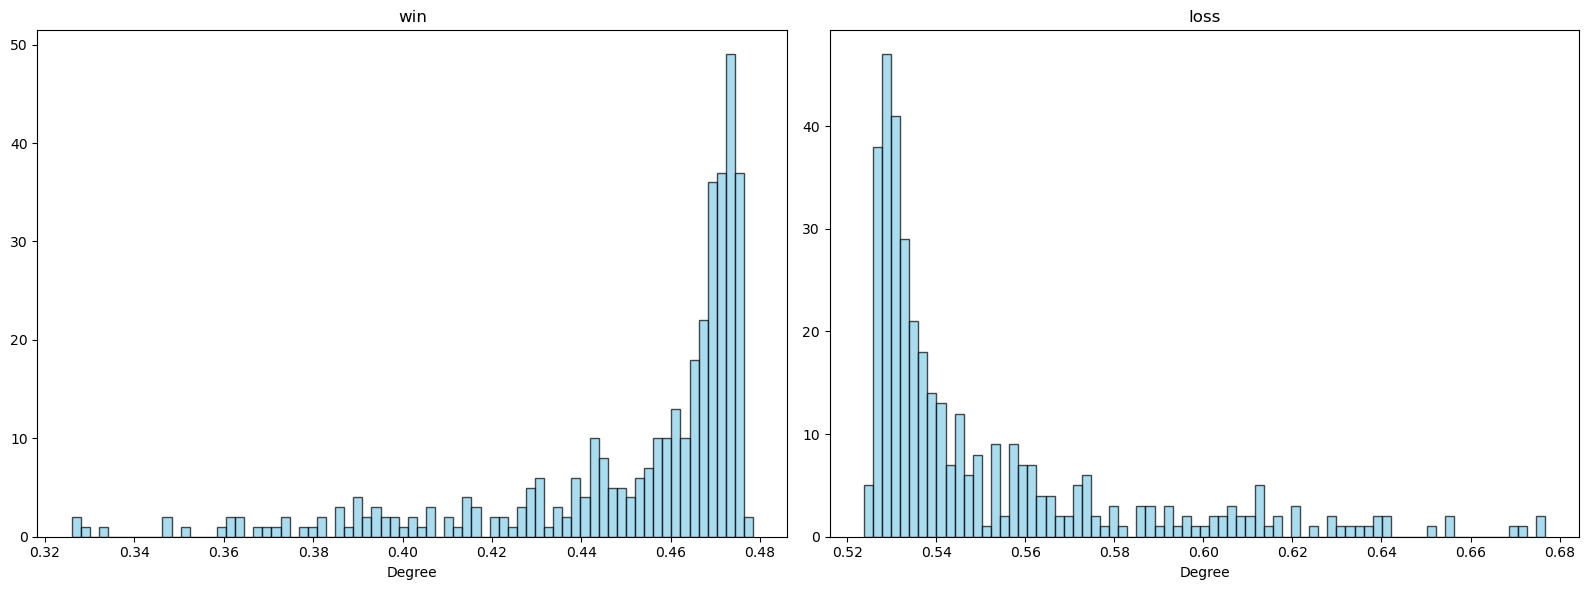

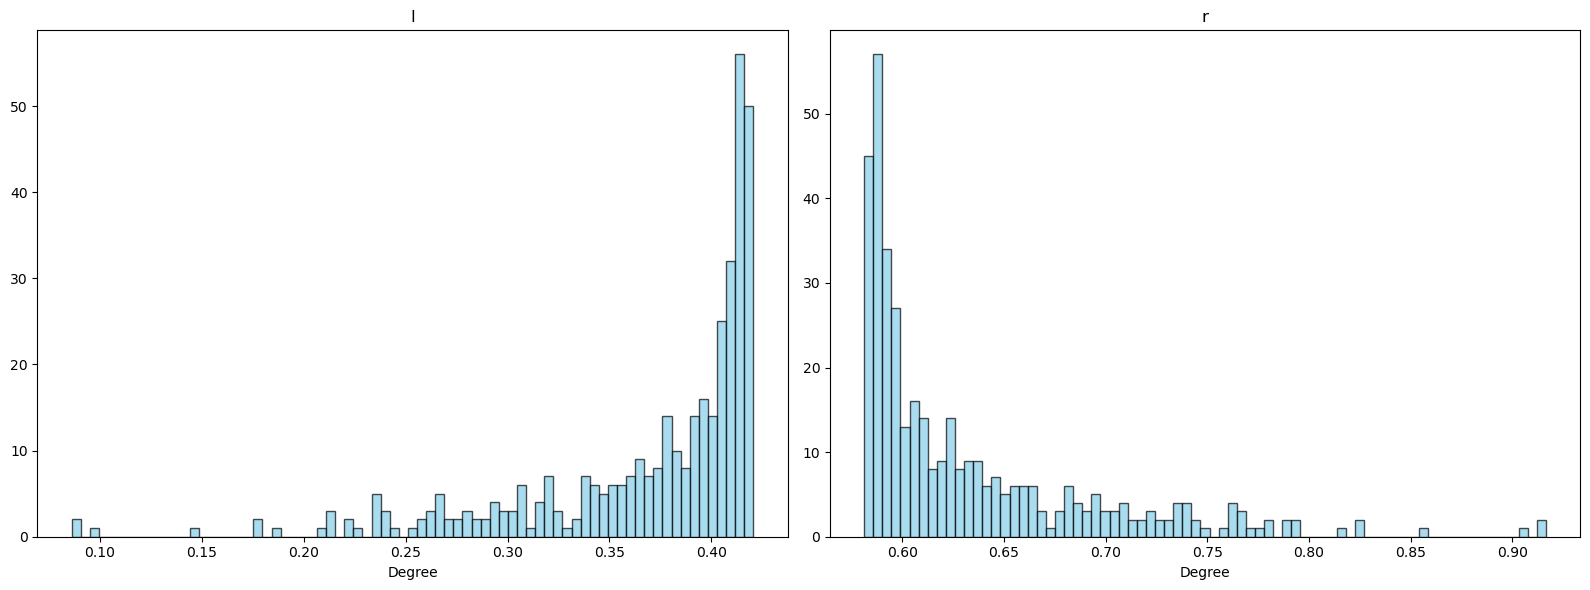

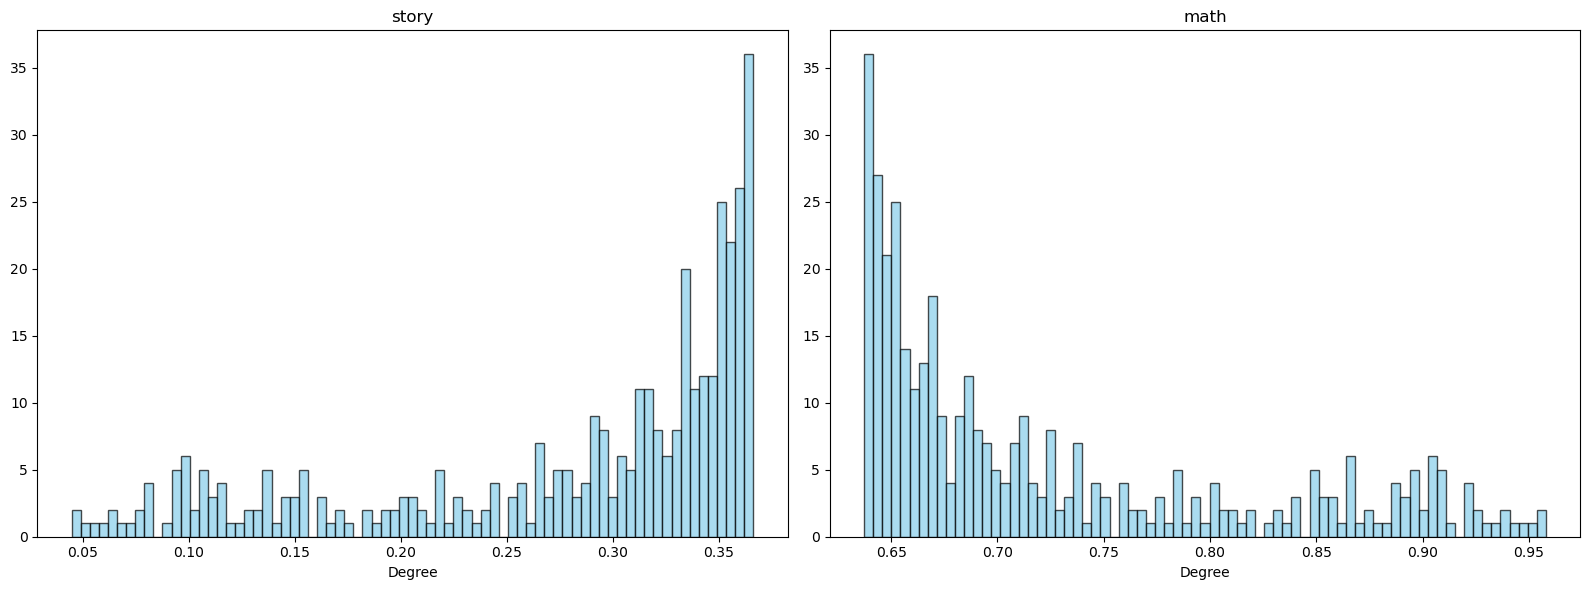

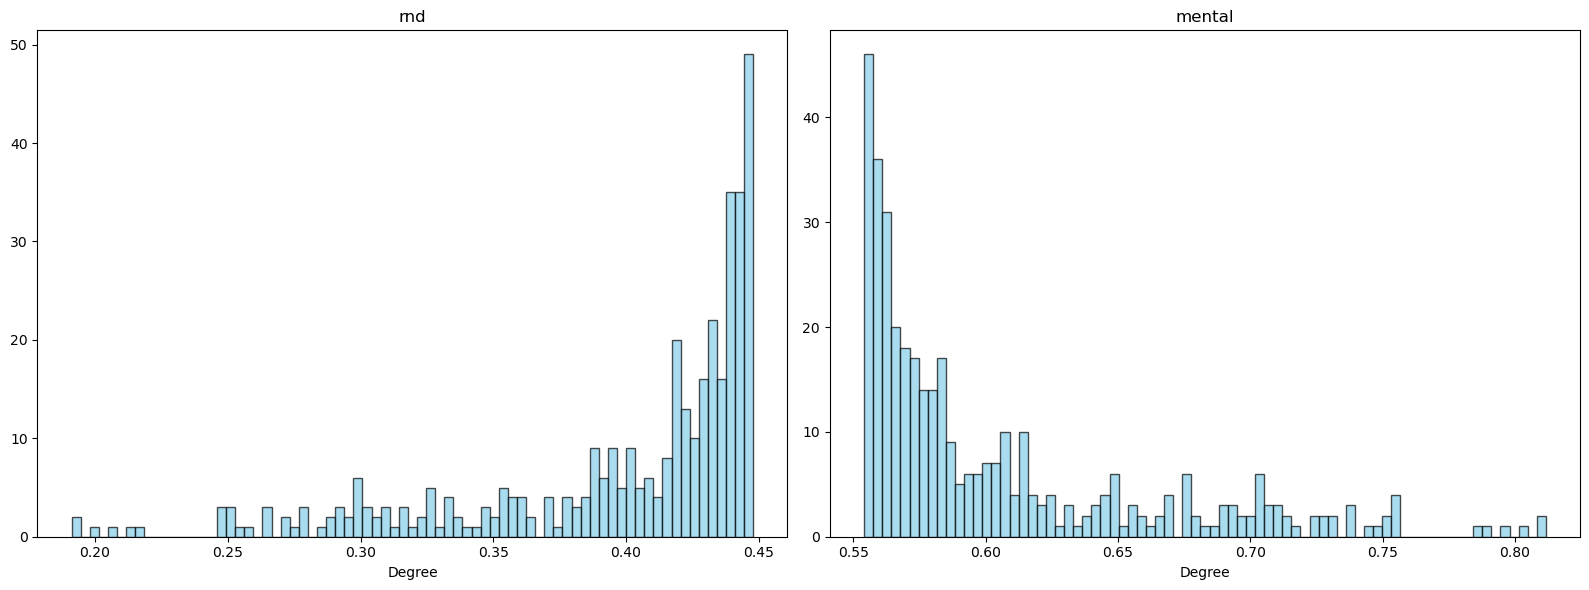

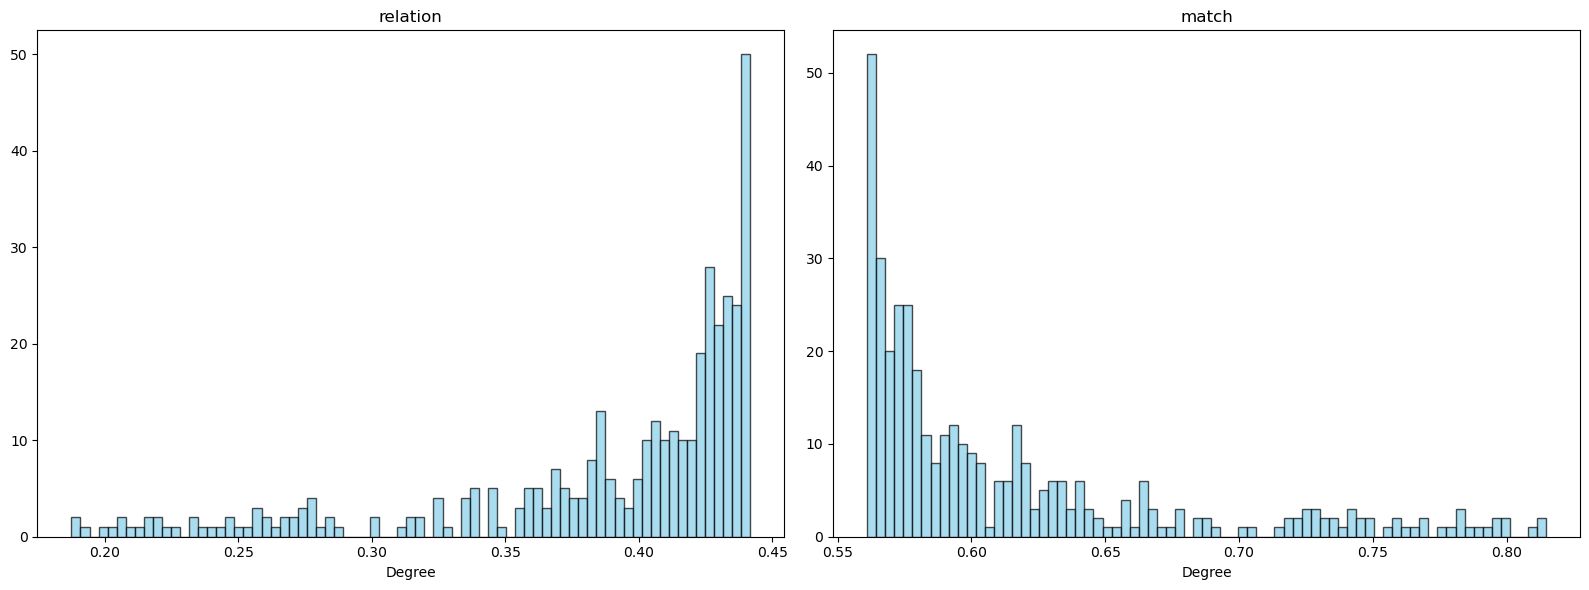

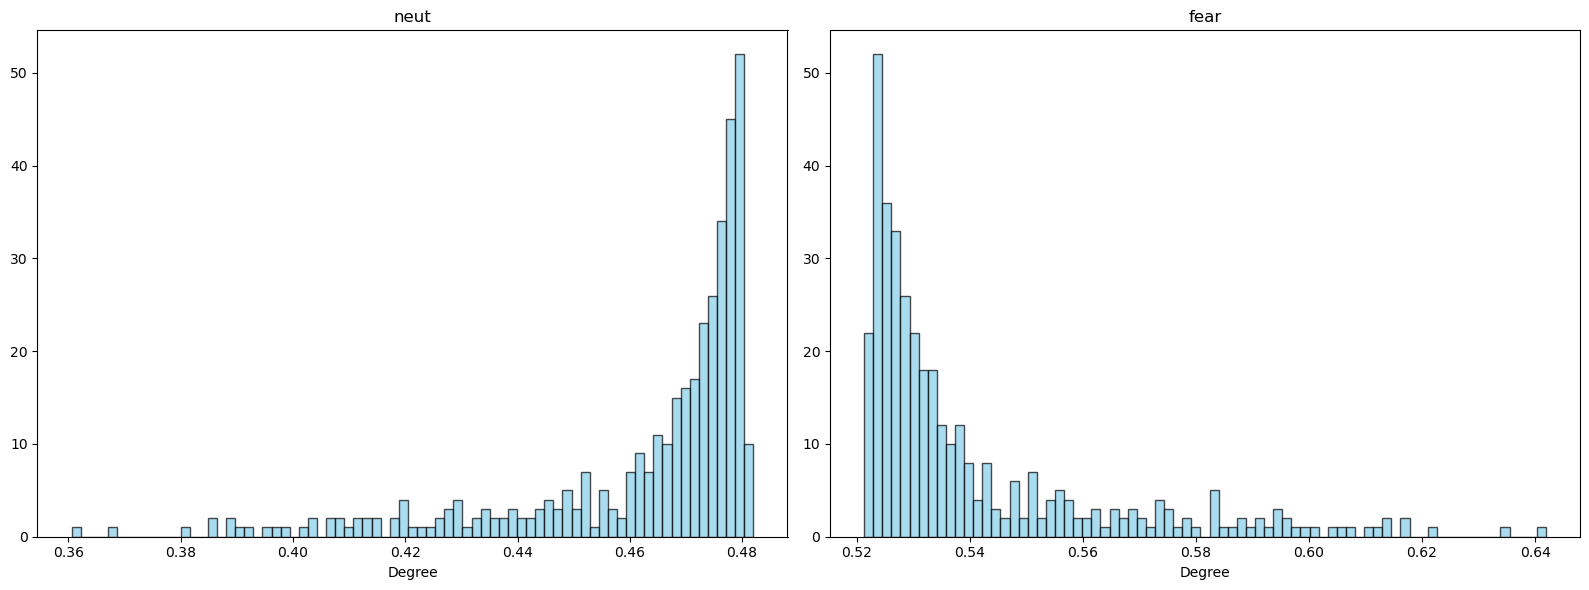

In [46]:
degree_distribution(paths.average_network_wm[0], paths.average_network_wm[1])
degree_distribution(paths.average_network_gambling[0], paths.average_network_gambling[1])
degree_distribution(paths.average_network_motor[0], paths.average_network_motor[1])
degree_distribution(paths.average_network_language[0], paths.average_network_language[1])
degree_distribution(paths.average_network_social[0], paths.average_network_social[1])
degree_distribution(paths.average_network_relational[0], paths.average_network_relational[1])
degree_distribution(paths.average_network_emotion[0], paths.average_network_emotion[1])

Сравним распределение степеней со степенным законом. Степени половины графов будут повернуты с помощью 1 - x. 

In [55]:
import numpy as np
import powerlaw
import matplotlib.pyplot as plt

def read_net(file, reflect):
    if reflect:
        G = nx.from_numpy_array(1 - np.load(file))
    else:
        G = nx.from_numpy_array(np.load(file))
    title = file.split('/')[-1][:-4]
    return G, title

def powerlaw_check(file, reflect=False):
    # Пример: массив данных. Замените этот пример своими данными.
    G, title = read_net(file, reflect)
    degrees = np.array([abs(d) for n, d in G.degree(weight='weight')]) / len(G.nodes)  
    
    print(title)
    # Выполним оценку параметров степенного закона
    fit = powerlaw.Fit(degrees)
    
    # Вывод оцененных параметров
    print("Оценка параметра степени (alpha):", fit.alpha)
    print("Минимальное значение (xmin):", fit.xmin)
    print("KS статистика:", fit.power_law.KS())
    
    # Построим график эмпирического распределения и подгонку степенного закона
    fig = fit.plot_cdf(label='Эмпирические данные')
    fit.power_law.plot_cdf(ax=fig, color='r', linestyle='--', label='Степенной закон')
    fit.exponential.plot_cdf(ax=fig, color='g', linestyle='--', label='Экспоненциальное распределение')
    plt.xlabel('x')
    plt.ylabel('CDF')
    plt.title(title)
    plt.legend()
    plt.show()

0bk
Calculating best minimal value for power law fit
Оценка параметра степени (alpha): 12.834853944155846
Минимальное значение (xmin): 0.5613459355534157
KS статистика: 0.04380407534500985


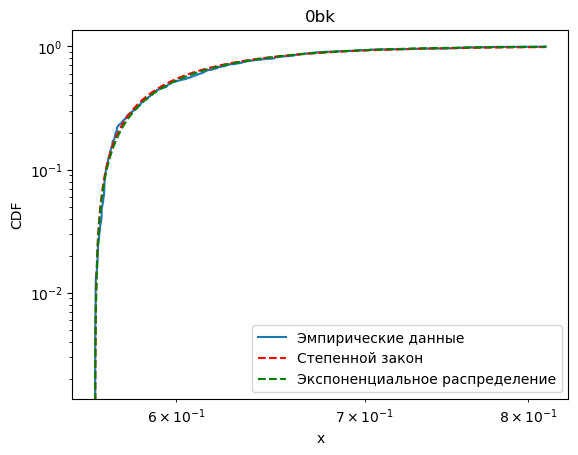

2bk
Calculating best minimal value for power law fit
Оценка параметра степени (alpha): 12.85626033998266
Минимальное значение (xmin): 0.5614687346726459
KS статистика: 0.04579375876938896


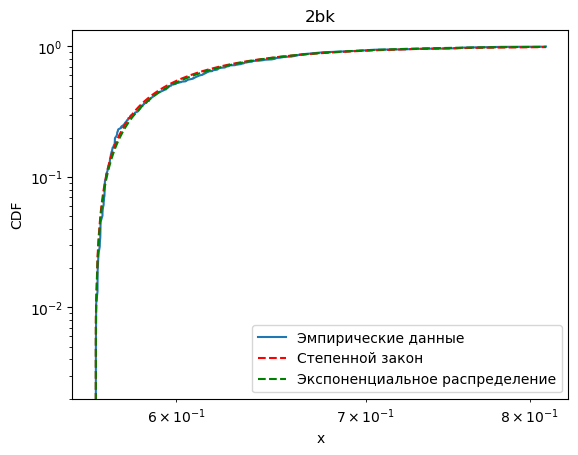

win
Calculating best minimal value for power law fit
Оценка параметра степени (alpha): 17.158730482562653
Минимальное значение (xmin): 0.5371430759276927
KS статистика: 0.05720883862053627


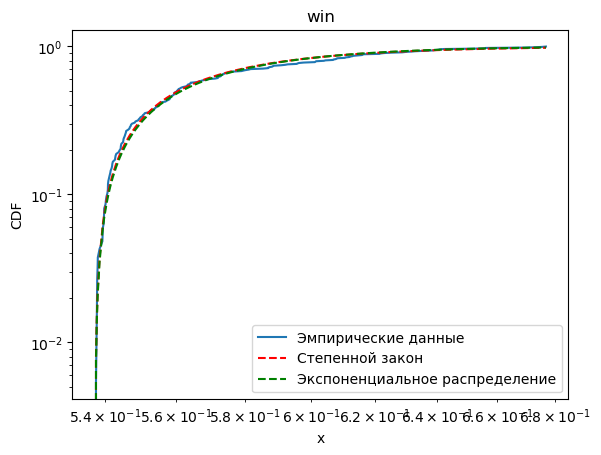

loss
Calculating best minimal value for power law fit
Оценка параметра степени (alpha): 16.935006381179804
Минимальное значение (xmin): 0.5373281213413426
KS статистика: 0.05697542510442688


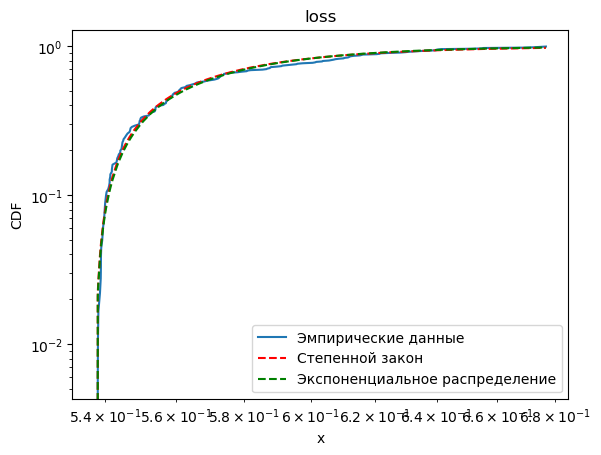

l
Calculating best minimal value for power law fit
Оценка параметра степени (alpha): 11.322789135225563
Минимальное значение (xmin): 0.5937587431334074
KS статистика: 0.047664684105998334


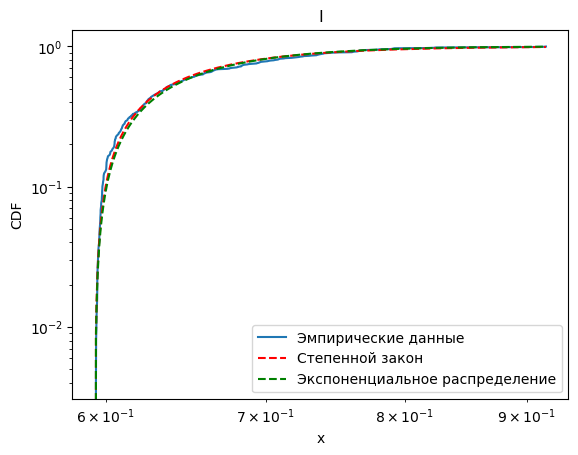

r
Calculating best minimal value for power law fit
Оценка параметра степени (alpha): 11.282767603761878
Минимальное значение (xmin): 0.5946968962716096
KS статистика: 0.04772084082459238


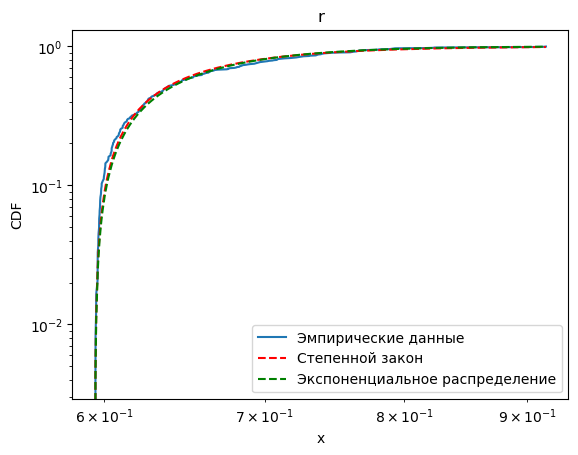

story
Calculating best minimal value for power law fit
Оценка параметра степени (alpha): 9.051497093821522
Минимальное значение (xmin): 0.639662394269135
KS статистика: 0.07910775032545059


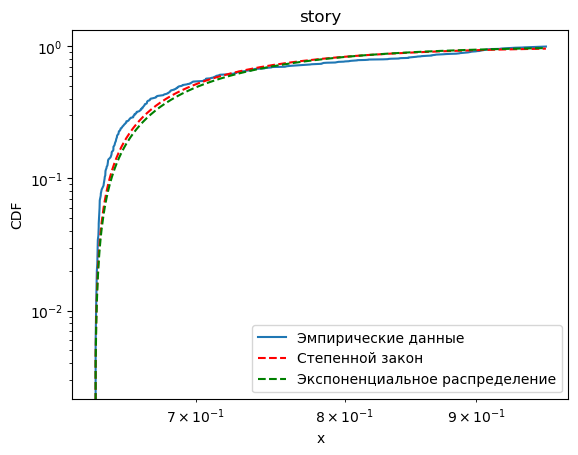

math
Calculating best minimal value for power law fit
Оценка параметра степени (alpha): 9.061945583194058
Минимальное значение (xmin): 0.6402048659693972
KS статистика: 0.07901829273853556


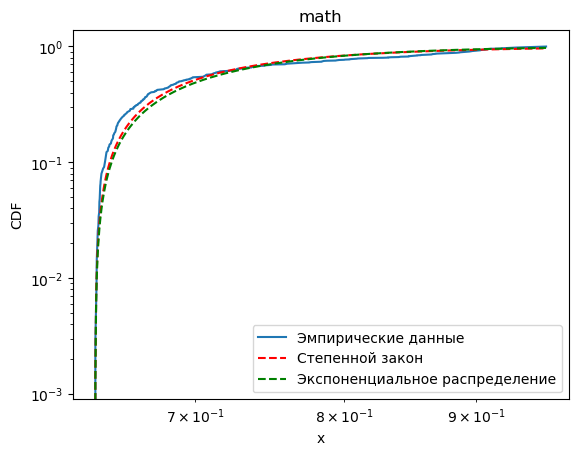

rnd
Calculating best minimal value for power law fit
Оценка параметра степени (alpha): 11.388668897124596
Минимальное значение (xmin): 0.5648866380503036
KS статистика: 0.06280094101821909


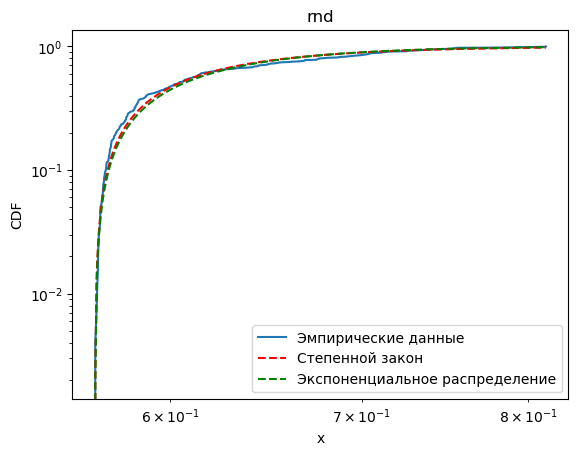

mental
Calculating best minimal value for power law fit
Оценка параметра степени (alpha): 11.454803161040177
Минимальное значение (xmin): 0.5632621915504342
KS статистика: 0.06231639490981733


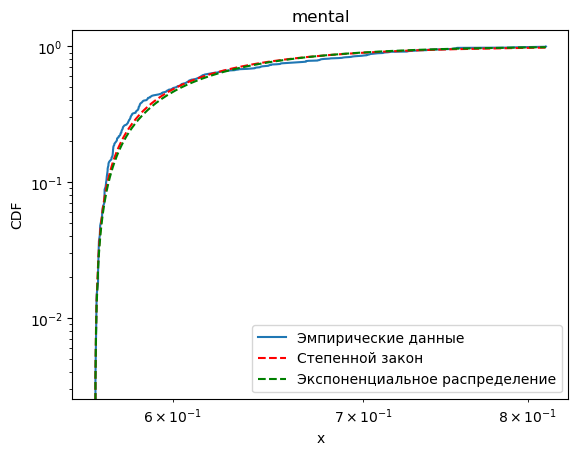

relation
Calculating best minimal value for power law fit
Оценка параметра степени (alpha): 11.30548144089256
Минимальное значение (xmin): 0.573154075145194
KS статистика: 0.06734010753220865


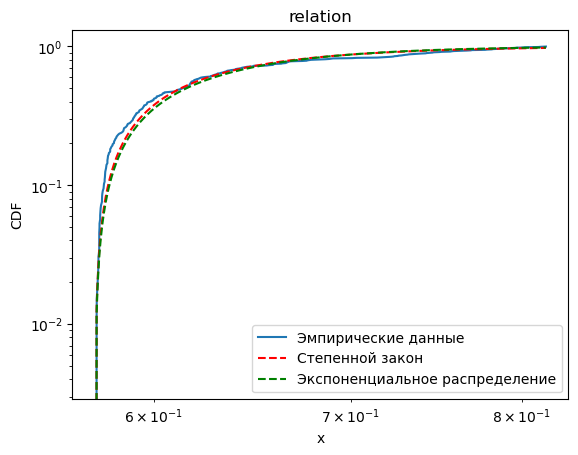

match
Calculating best minimal value for power law fit
Оценка параметра степени (alpha): 11.09877978218094
Минимальное значение (xmin): 0.5747874961823595
KS статистика: 0.0695274331768666


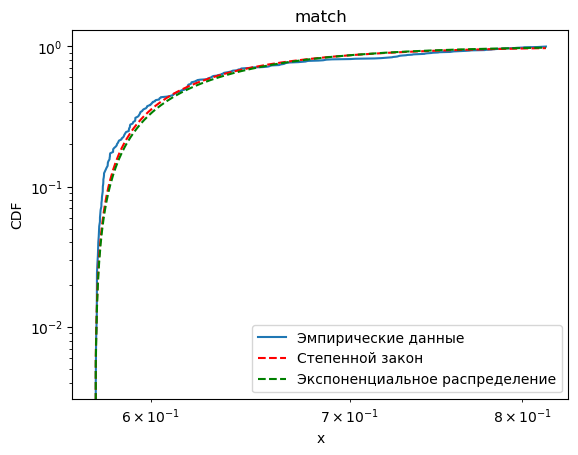

neut
Calculating best minimal value for power law fit
Оценка параметра степени (alpha): 22.003733865200044
Минимальное значение (xmin): 0.5340313790713979
KS статистика: 0.06130196225095885


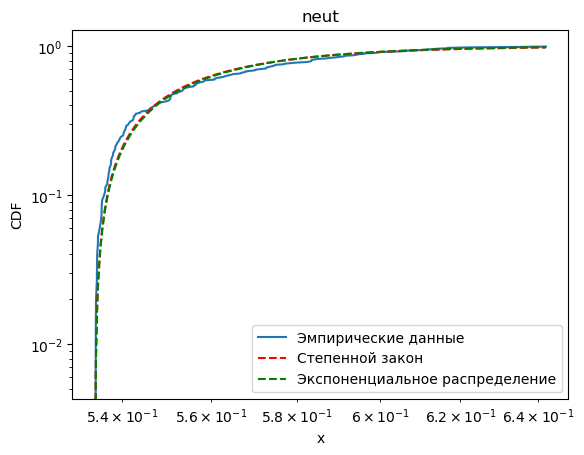

fear
Calculating best minimal value for power law fit
Оценка параметра степени (alpha): 22.005086324247976
Минимальное значение (xmin): 0.5342529699338682
KS статистика: 0.06314679502141496


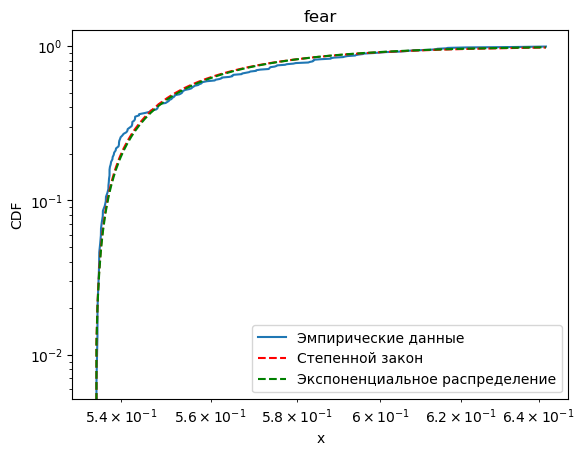

In [50]:
powerlaw_check(paths.average_network_wm[0], True)
powerlaw_check(paths.average_network_wm[1])
powerlaw_check(paths.average_network_gambling[0], True)
powerlaw_check(paths.average_network_gambling[1])
powerlaw_check(paths.average_network_motor[0], True)
powerlaw_check(paths.average_network_motor[1])
powerlaw_check(paths.average_network_language[0], True)
powerlaw_check(paths.average_network_language[1])
powerlaw_check(paths.average_network_social[0], True)
powerlaw_check(paths.average_network_social[1])
powerlaw_check(paths.average_network_relational[0], True)
powerlaw_check(paths.average_network_relational[1])
powerlaw_check(paths.average_network_emotion[0], True)
powerlaw_check(paths.average_network_emotion[1])

С уровнем значимости 0.05 гипотеза о том, что степени вершин распределены в соответствии со степенным законом у некоторых данных. С уровнем значимости 0.1 у всех.

In [62]:
def degree_correlation_matrix(file0, file1, reflect=False, bins=50):
    """
    Изображает матрицы корреляций степеней для двух графов.
    
    Для каждого графа:
      - Вычисляются степени узлов (нормированные на число узлов).
      - Для каждого ребра извлекается пара степеней соединённых узлов.
      - По парам степеней строится 2D-гистограмма (heatmap), где оси соответствуют степеням двух узлов.
    
    Параметры:
      :param file0: Файл графа первого состояния.
      :param file1: Файл графа второго состояния.
      :param bins: Число бинов (ячейки) по каждой оси гистограммы.
      :param reflect: Применять ли сдвиг весов (если требуется).
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    Gs, titles = read_nets(file0, file1, reflect)
    
    for ax, G, title in zip(axes, Gs, titles):
        # Вычисляем степени для всех узлов (нормированные на общее число узлов)
        degrees = {n: d/len(G.nodes) for n, d in G.degree(weight='weight')}  
        
        # Собираем пары степеней для каждого ребра
        d1_list = []
        d2_list = []
        for u, v in G.edges():
            d1_list.append(degrees[u])
            d2_list.append(degrees[v])
        d1 = np.array(d1_list)
        d2 = np.array(d2_list)
        
        # Вычисляем 2D-гистограмму по парам степеней.
        # Диапазон выставляем от -1 до 1 (так как степени лежат в этом интервале)
        H, xedges, yedges = np.histogram2d(d1, d2, bins=bins, range=[[0, 1], [0, 1]])
        
        # Отображаем тепловую карту. Транспонирование H.T обеспечивает правильную ориентацию.
        im = ax.imshow(H.T, origin='lower', extent=[0, 1, 0, 1],
                       cmap='Blues', aspect='auto')
        ax.set_xlabel('Степень узла u')
        ax.set_ylabel('Степень узла v')
        ax.set_title(title)
        fig.colorbar(im, ax=ax, label='Частота ребер')
    
    plt.tight_layout()
    plt.show()


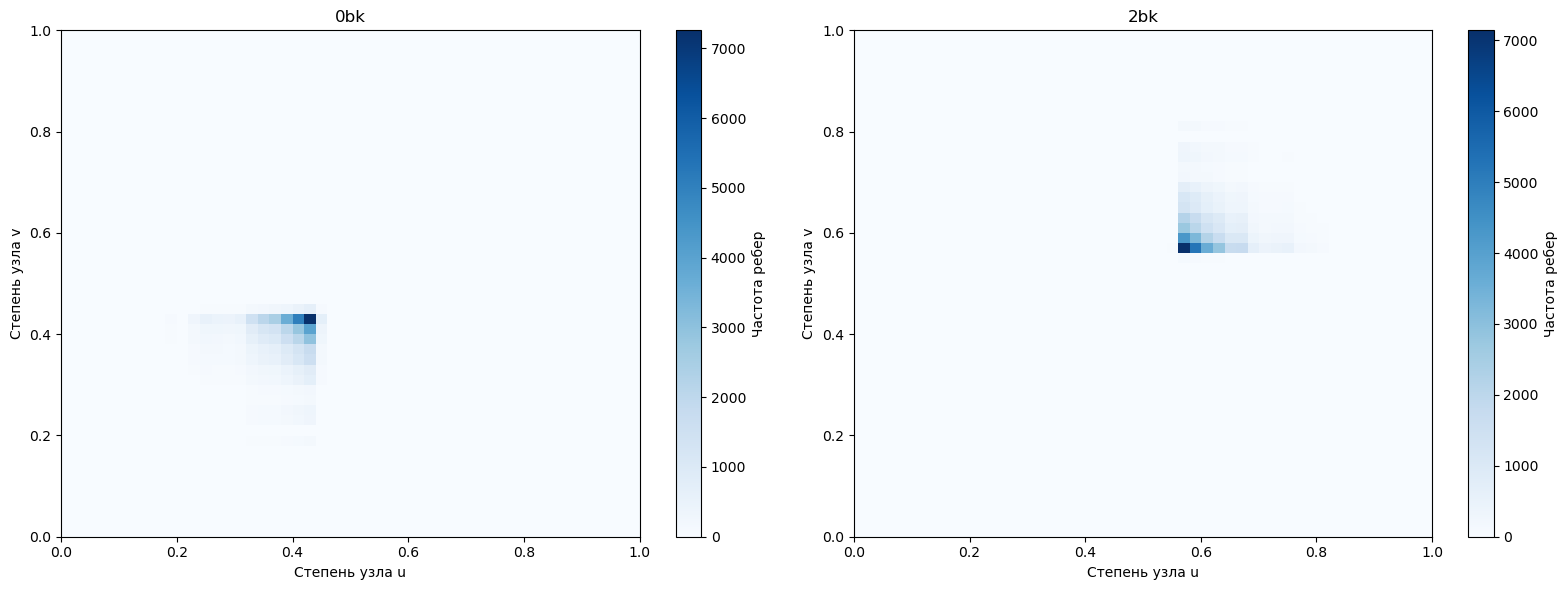

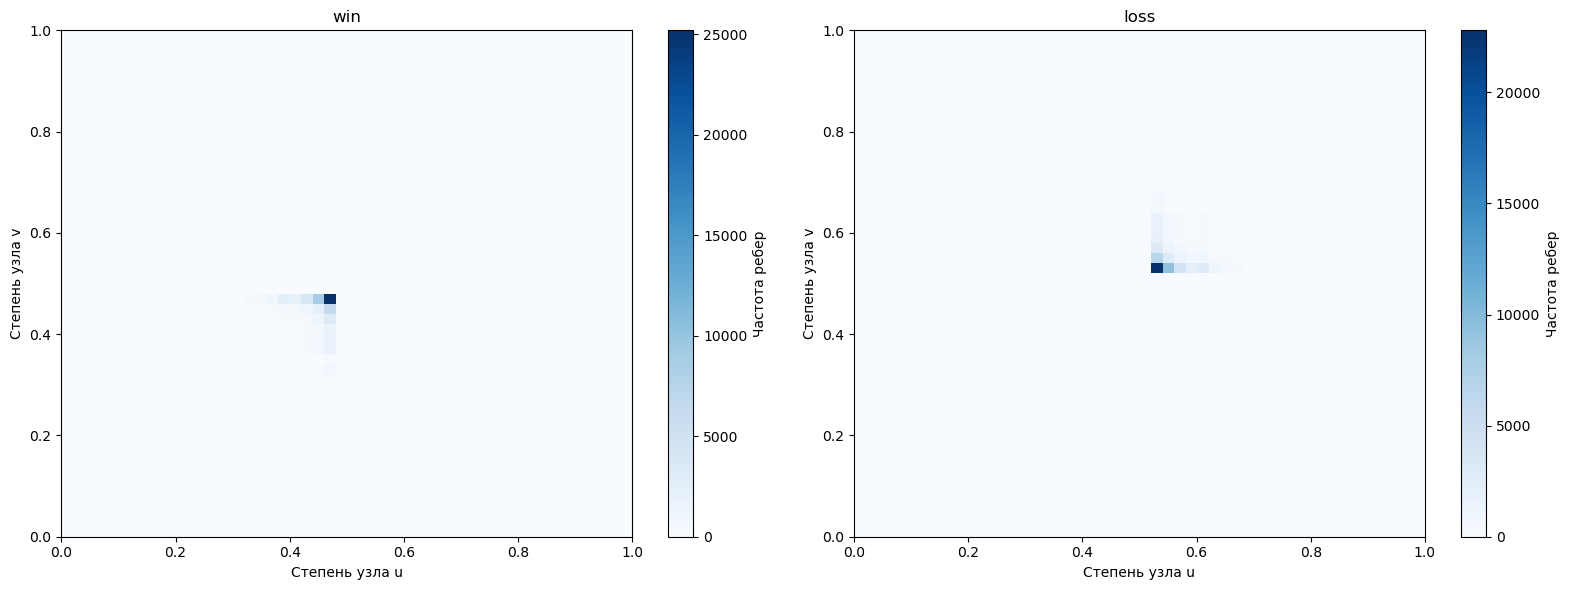

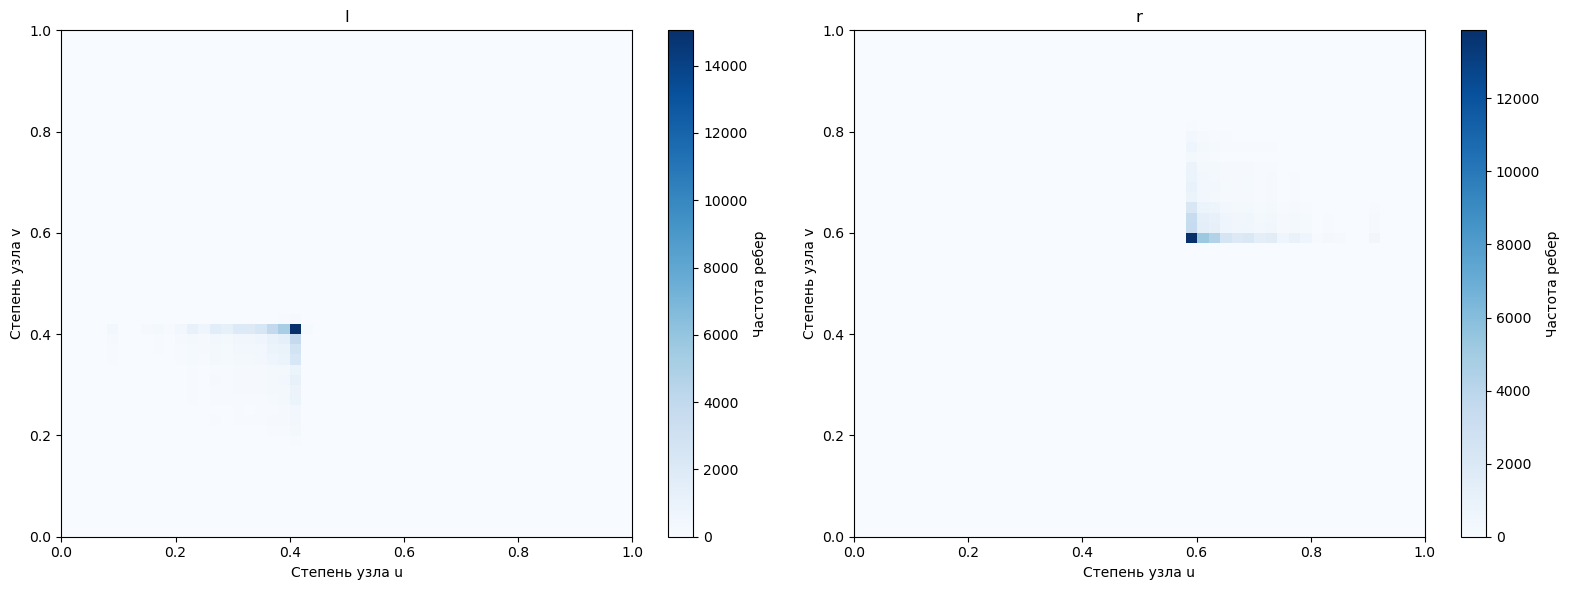

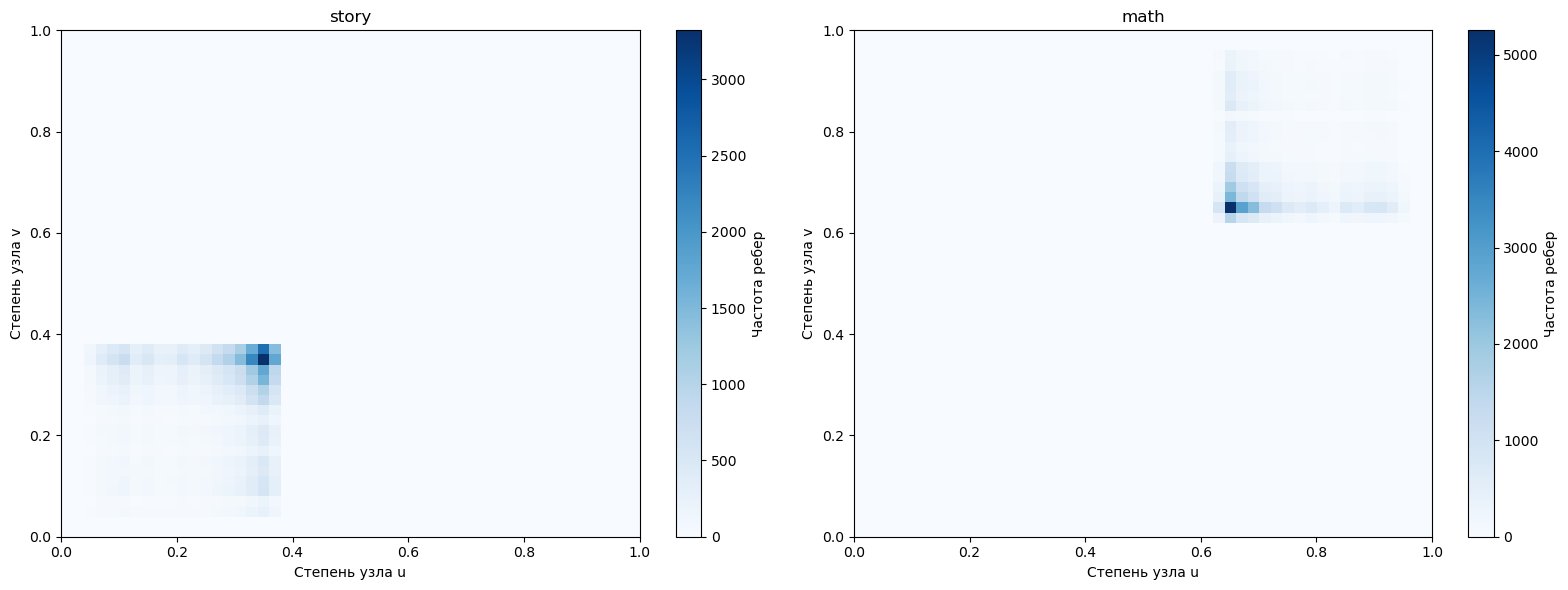

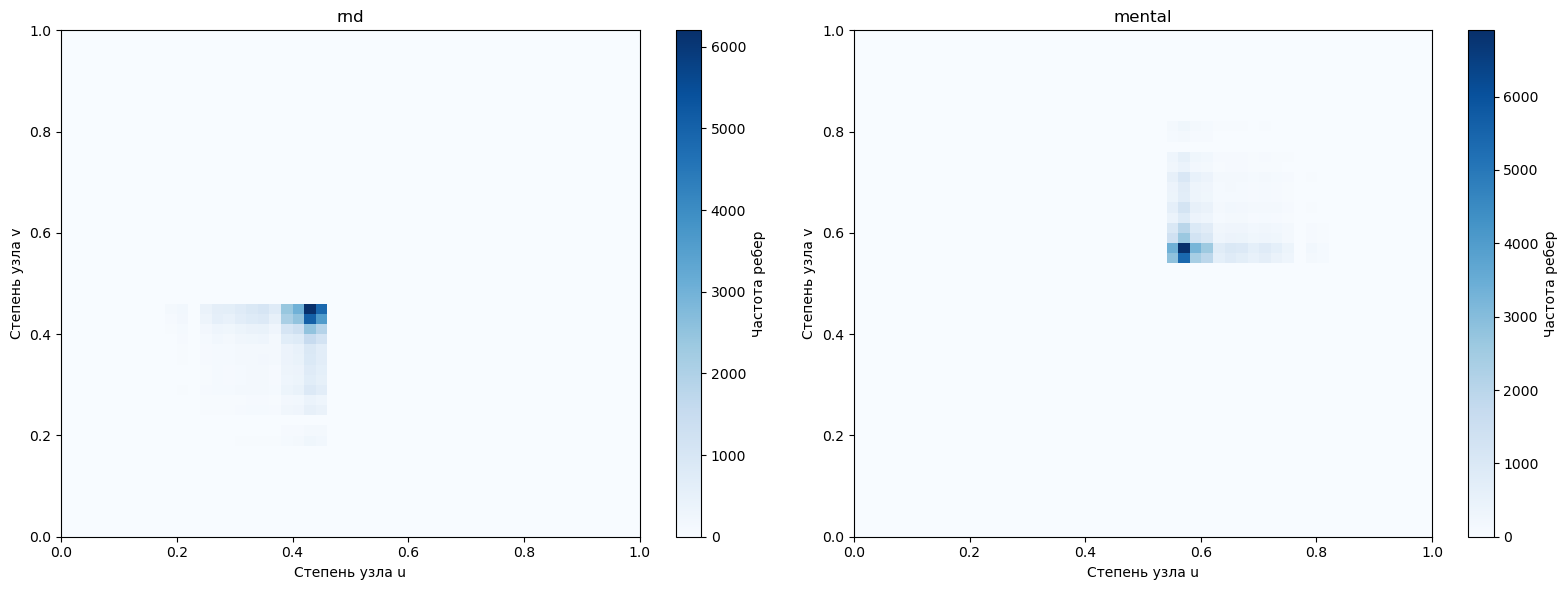

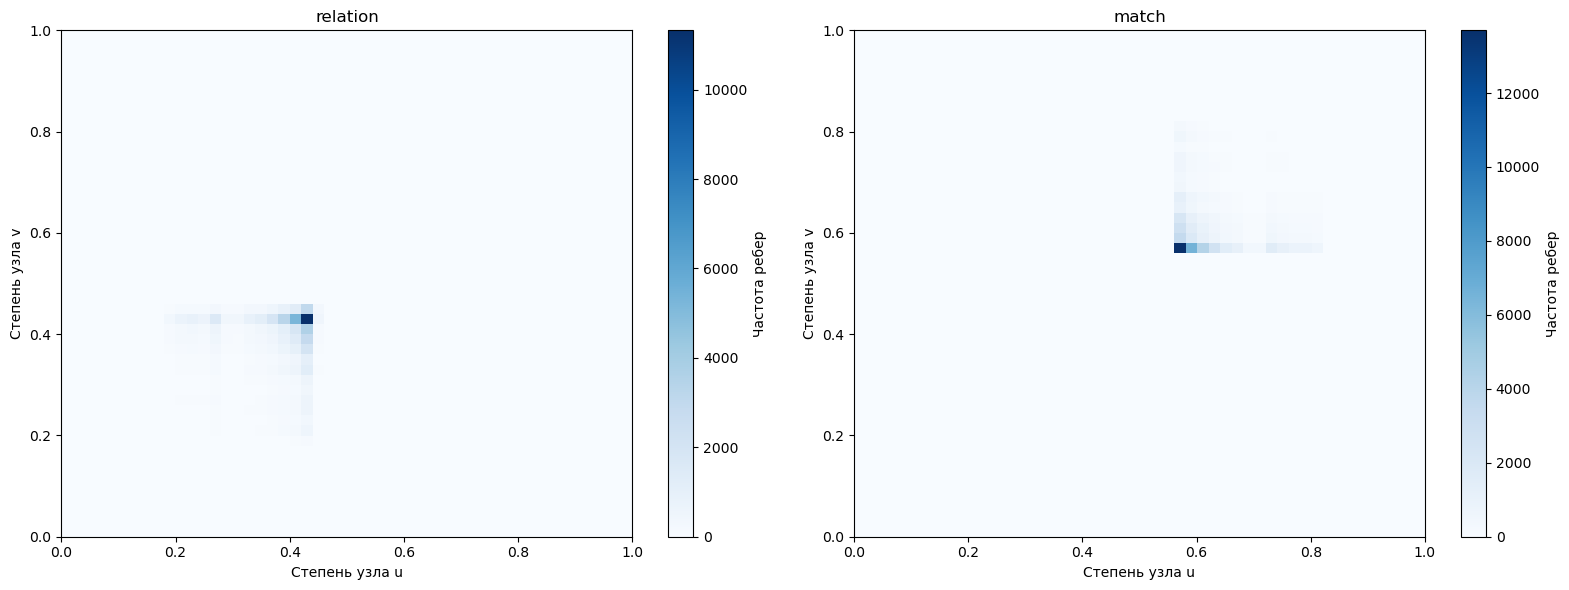

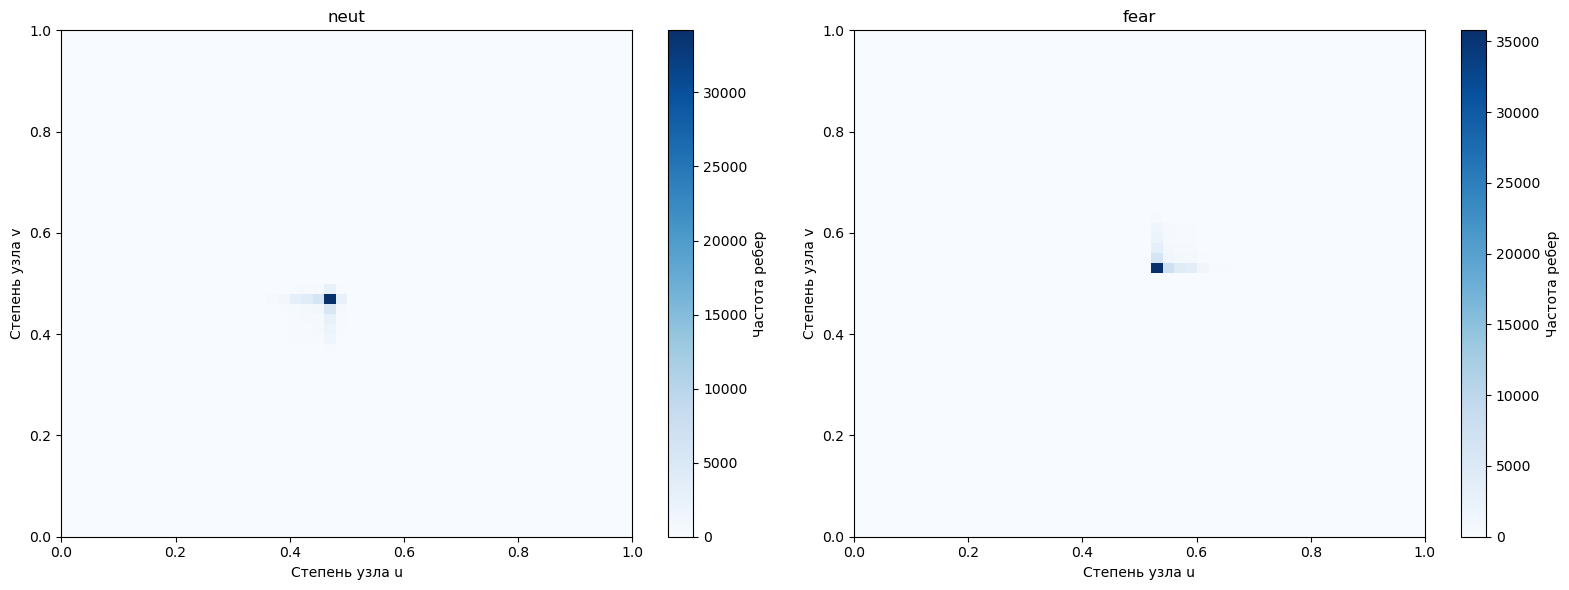

In [63]:
degree_correlation_matrix(paths.average_network_wm[0], paths.average_network_wm[1])
degree_correlation_matrix(paths.average_network_gambling[0], paths.average_network_gambling[1])
degree_correlation_matrix(paths.average_network_motor[0], paths.average_network_motor[1])
degree_correlation_matrix(paths.average_network_language[0], paths.average_network_language[1])
degree_correlation_matrix(paths.average_network_social[0], paths.average_network_social[1])
degree_correlation_matrix(paths.average_network_relational[0], paths.average_network_relational[1])
degree_correlation_matrix(paths.average_network_emotion[0], paths.average_network_emotion[1])

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats

def degree_correlation_function(file0, file1, shift=False):
    """
    Вычисляет функцию корреляции степеней для двух графов и строит scatter plot:
      - Для каждого узла вычисляется его нормализованная степень (с учётом весов ребер).
      - Для каждого узла считается средняя степень его соседей.
      - На графике по оси X откладывается степень узла, по оси Y – средняя степень соседей.
      - На scatter plot накладывается линия линейной регрессии.
    """
    Gs, titles = read_nets(file0, file1, shift)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for ax, G, title in zip(axes, Gs, titles):
        # Вычисляем нормализованные степени узлов (значение может быть отрицательным)
        degrees = {n: d/len(G.nodes) for n, d in G.degree(weight='weight')}
        
        # Для каждого узла вычисляем среднюю степень его соседей (если у узла есть соседи)
        node_degrees = []
        neighbor_avg_degrees = []
        
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            avg_neighbor_degree = np.mean([degrees[neigh] for neigh in neighbors])
            node_degrees.append(degrees[node])
            neighbor_avg_degrees.append(avg_neighbor_degree)
        
        node_degrees = np.array(node_degrees)
        neighbor_avg_degrees = np.array(neighbor_avg_degrees)
        
        # Строим scatter plot точек: (степень узла, средняя степень его соседей)
        ax.scatter(node_degrees, neighbor_avg_degrees, color='blue', alpha=0.6, label='Точки данных')
        
        # Выполняем линейную регрессию для нахождения линии тренда
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(node_degrees, neighbor_avg_degrees)
        
        # Создаём массив значений по оси X для линии регрессии
        x_vals = np.linspace(np.min(node_degrees), np.max(node_degrees), 100)
        y_vals = intercept + slope * x_vals
        ax.plot(x_vals, y_vals, color='red', linestyle='--',
                label=f'Линия регрессии\nslope={slope:.2f}')
        
        ax.set_title(title)
        ax.set_xlabel('Степень узла')
        ax.set_ylabel('Средняя степень соседей')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

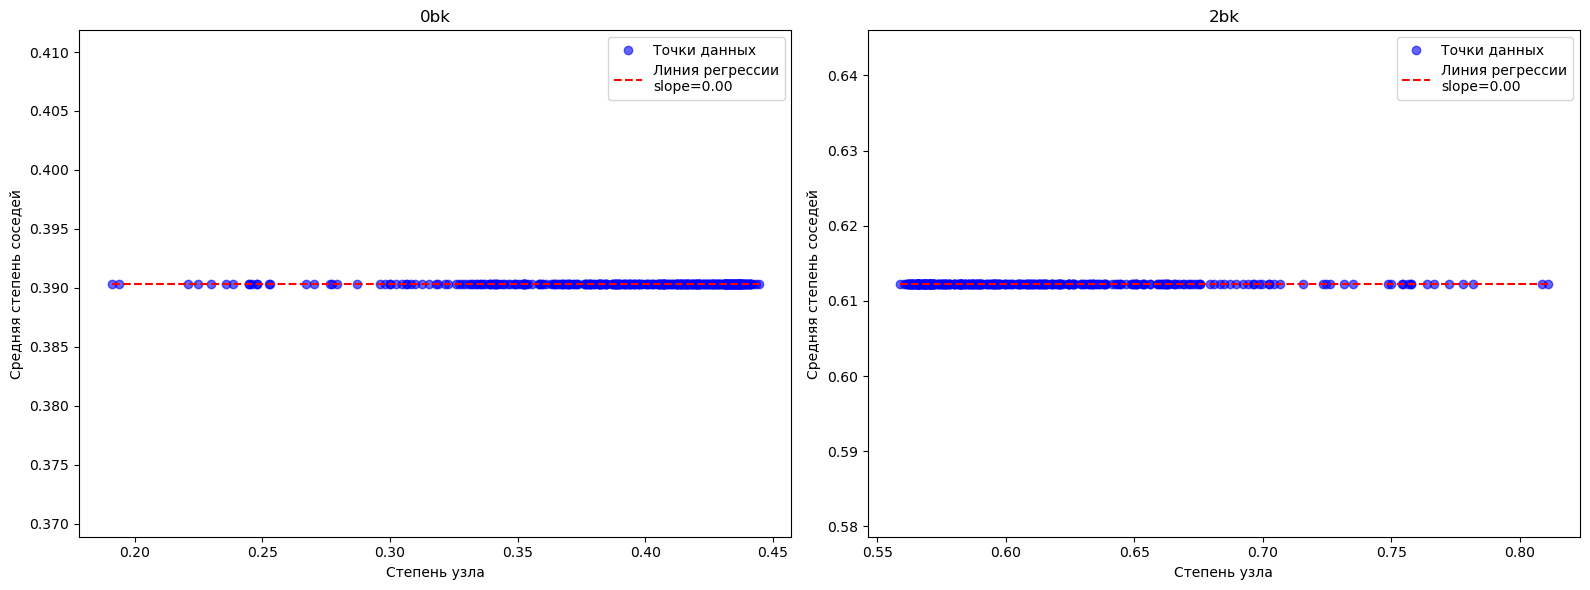

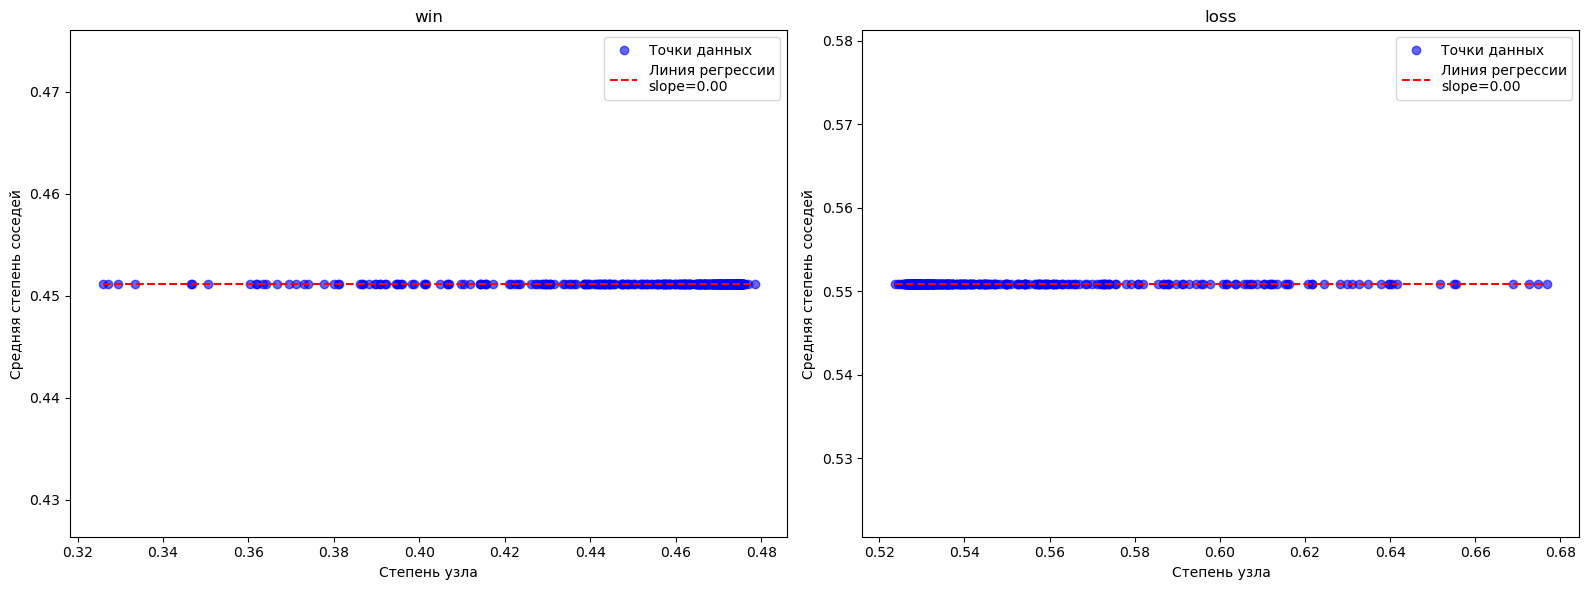

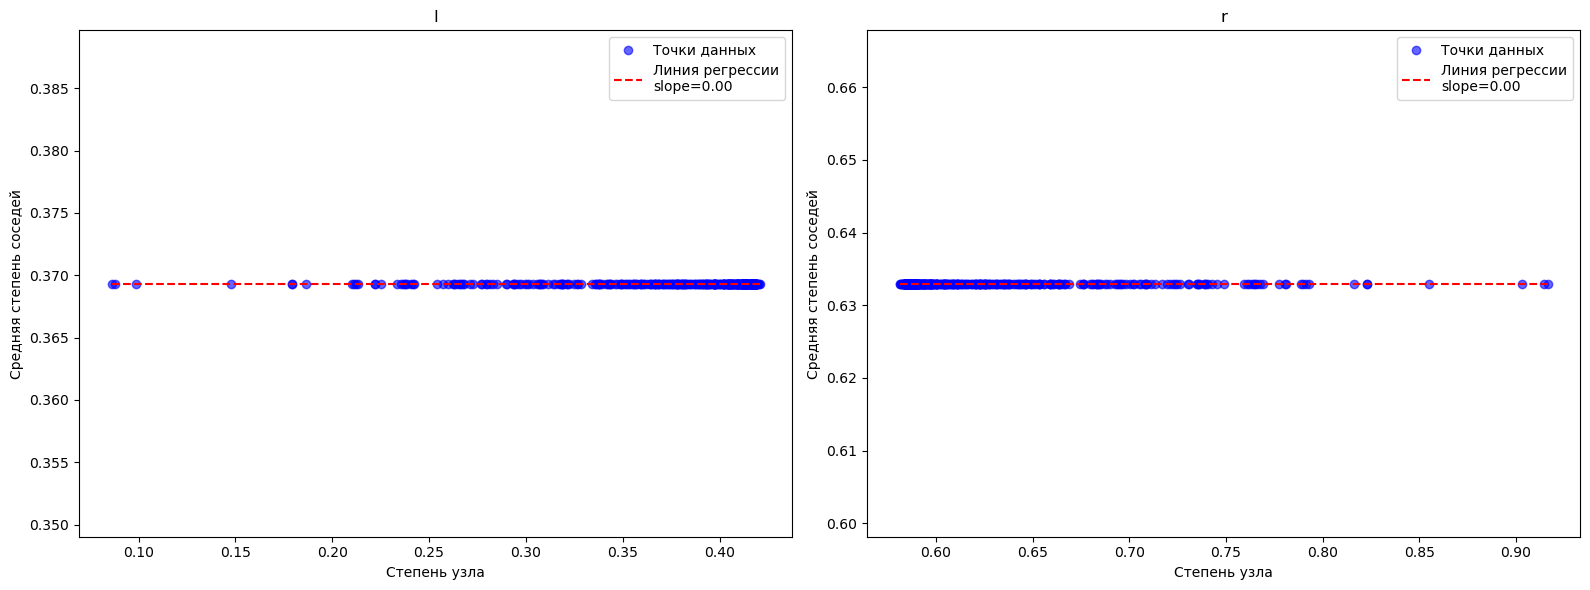

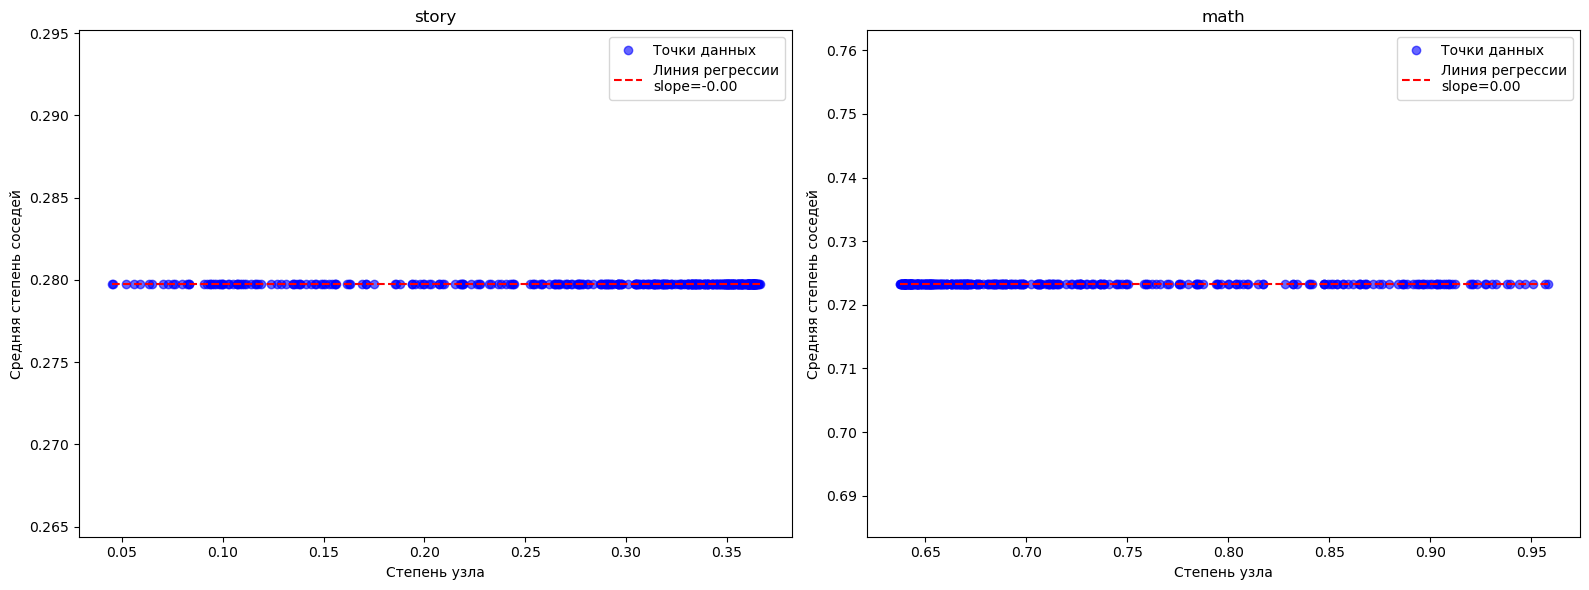

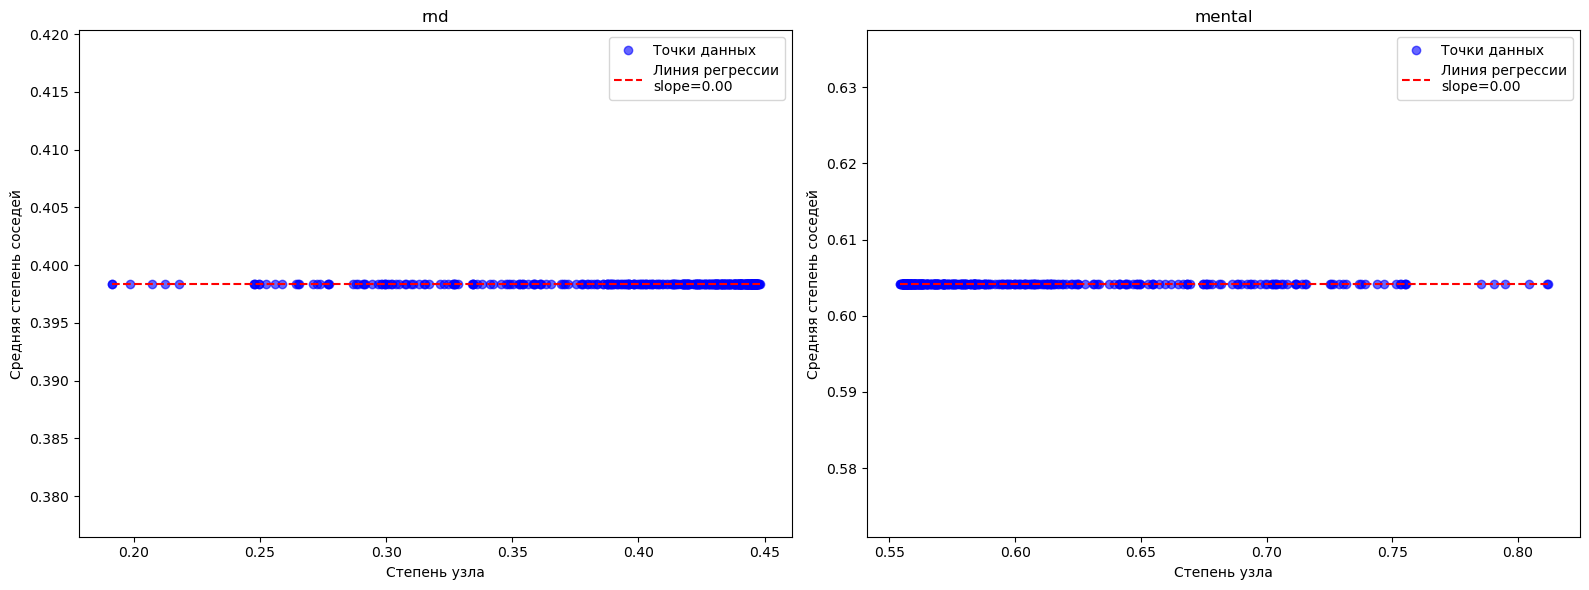

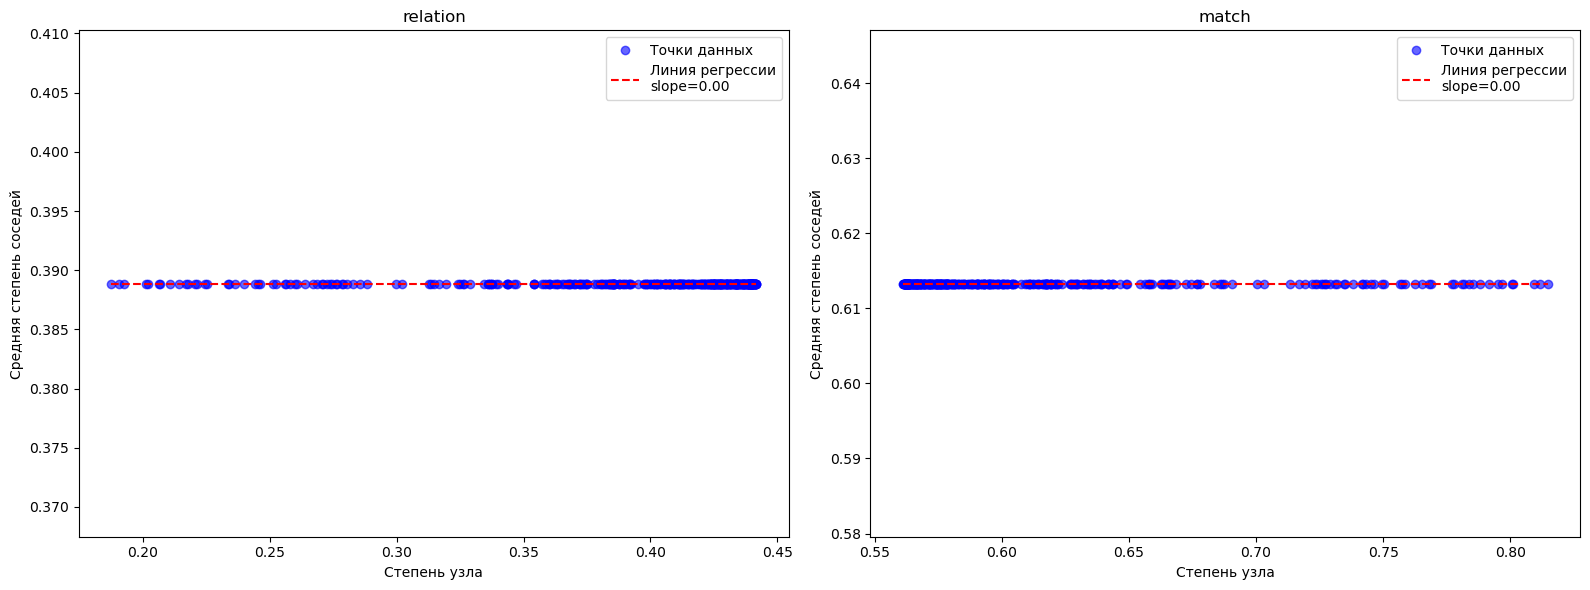

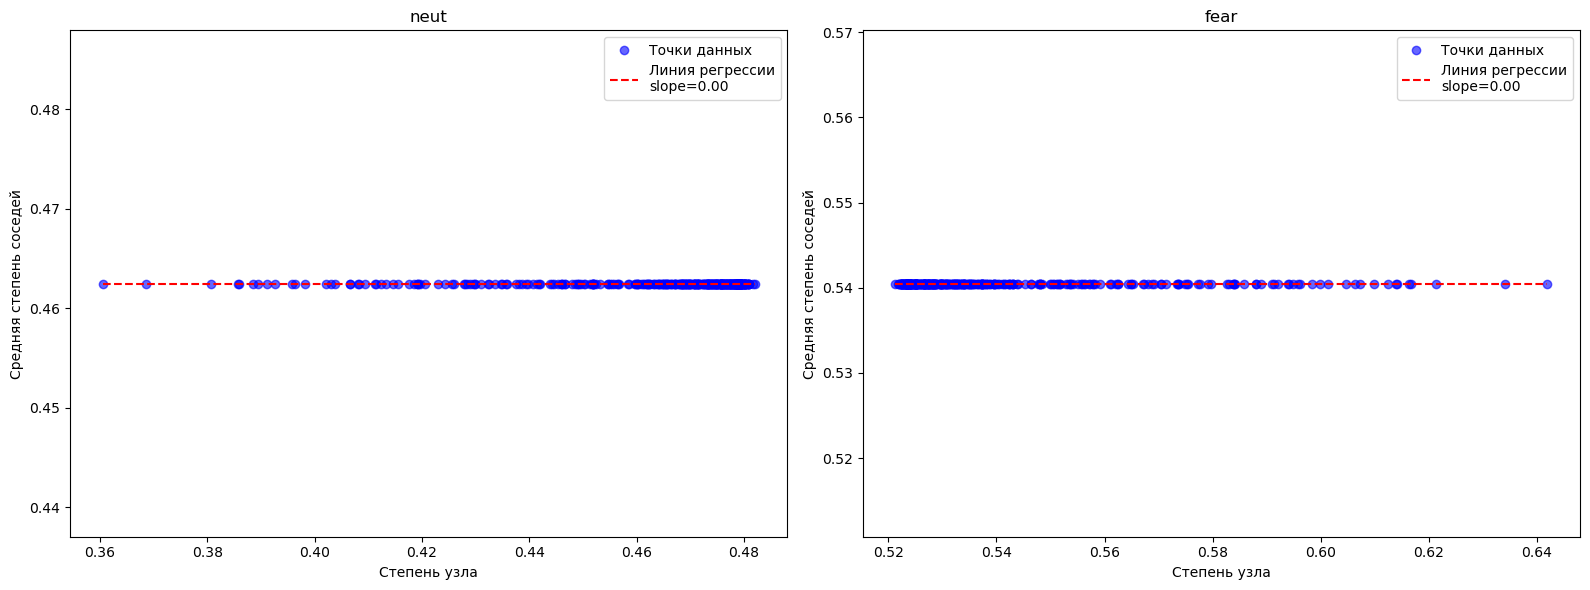

In [75]:
degree_correlation_function(paths.average_network_wm[0], paths.average_network_wm[1])
degree_correlation_function(paths.average_network_gambling[0], paths.average_network_gambling[1])
degree_correlation_function(paths.average_network_motor[0], paths.average_network_motor[1])
degree_correlation_function(paths.average_network_language[0], paths.average_network_language[1])
degree_correlation_function(paths.average_network_social[0], paths.average_network_social[1])
degree_correlation_function(paths.average_network_relational[0], paths.average_network_relational[1])
degree_correlation_function(paths.average_network_emotion[0], paths.average_network_emotion[1])

Ну это логично, граф то полный, лол. Средний вес соседа для любой вершины почти всегда одинаковый.... 